In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from scipy import stats
import seaborn as sns
import json
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

In [2]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"

#Source NL https://pageviews.wmcloud.org/?project=nl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Bezorgdheid|Eenzaamheid|Slapeloosheid|Depressie_(klinisch)
#Source IT https://pageviews.wmcloud.org/?project=it.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Ansia|Disturbo_depressivo|Insonnia|Solitudine
#Source PL https://pageviews.wmcloud.org/?project=pl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=L%C4%99k|Zaburzenia_depresyjne|Bezsenno%C5%9B%C4%87%7CSamotno%C5%9B%C4%87%7CStres
#Source SV https://pageviews.wmcloud.org/?project=sv.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Ångest|Depression|Sömnlöshet|Ensamhet|Stress

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl_2019.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it_2019.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl_2019.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv_2019.csv"


In [3]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

LANG_TEXTS = {'nl': 'Dutch', 'sv': 'Swedish', 'pl': 'Polish', 'it': 'Italian'}

In [4]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [5]:
interventions_data.set_index('lang', inplace=True)

In [6]:
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [7]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

In [8]:
def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang] 
    if start is pd.NaT:
        start = interventions_data['Mobility'].loc[lang] 
    end = interventions_data['Normalcy'].loc[lang]
    if start is pd.NaT or end is pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

In [9]:
def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['Month'] = df['Date'].apply(lambda x: x.strftime('%m/%Y')) #add month
    df['Year'] = df['Date'].apply(lambda x: str(x.strftime('%Y')))
    
    # interquartile range approach for deleting outliers
    for diseas in diseases_names['en']:
        Q1 = df[diseas].quantile(0.25)
        Q3 = df[diseas].quantile(0.75)
        IQR = Q3 - Q1    

        df[diseas] = np.clip(np.array(df[diseas]), Q1 - 1.5 * IQR, Q3 + 1.5 *IQR)  

    # df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Date', 'Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'Month', 'Year']]
    return df

In [10]:
LANGUAGES = ['nl', 'sv', 'pl', 'it']
#each array with have 5 elements, one for each disease
#the order of the diseases will be :  'anxiety', 'depression', 'insomnia', 'loneliness', 'stress'

In [11]:
for lang in LANGUAGES:
    pageviews_data[lang] = get_pageviews_data(lang)

In [12]:
pageviews_data['it']

,anxiety,depression,insomnia,loneliness,stress,Date,Day_of_the_week,first_case,first_death,lockdown,Month,Year
0,283.0,466.0,162.0,109.0,51.0,2019-01-01,Tuesday,0,0,0,01/2019,2019
1,344.0,547.0,202.0,100.0,94.0,2019-01-02,Wednesday,0,0,0,01/2019,2019
2,319.0,547.0,242.0,68.0,87.0,2019-01-03,Thursday,0,0,0,01/2019,2019
3,349.0,523.0,218.0,77.0,96.0,2019-01-04,Friday,0,0,0,01/2019,2019
4,337.0,489.0,172.0,81.0,99.0,2019-01-05,Saturday,0,0,0,01/2019,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
604,211.0,481.0,131.0,46.0,91.0,2020-08-27,Thursday,0,0,0,08/2020,2020
605,215.0,455.0,160.0,43.0,109.0,2020-08-28,Friday,0,0,0,08/2020,2020
606,215.0,507.0,194.0,47.0,90.0,2020-08-29,Saturday,0,0,0,08/2020,2020
607,242.0,536.0,219.0,49.0,112.0,2020-08-30,Sunday,0,0,0,08/2020,2020


# Distance from normality

We introduce a notion of “distance from normality” as follows. On each day, the pageviews in a given language edition form a distribution over mental health articles, characterizing how users’ attention was distributed. We represent each daily distribution as an “attention vector” of dimension 5 with one entry per article and entries summing to 1.

The notion of “normal” attention is captured by the average attention vector over all days of 2019, i.e., well before the pandemic; and for each subsequent day, the distance from normality is given by the Euclidean distance of that day’s attention vector from the average attention vector. Notice that we calculated the attention vector separately for each language edition.

We use this metric to understand overall changes in the information-seeking patterns of Wikipedia users on mental health articles.

In [17]:
#  Let's for each language find a "normal” attention vector and for each day calculate the distance from "normal” attention vector.
for lang in LANGUAGES:
    # page views for a given language
    pageviews = pageviews_data[lang].copy()
    
    # page views a given language in 2019
    pageviews_2019 = pageviews[pageviews['Date'].dt.date < datetime.strptime('2020-01-01', '%Y-%m-%d').date()]
    
    # Normalize pageviews for 2019 such that for each day entries summing to 1.
    pageviews_attention_vector_2019 = np.array(pageviews_2019[diseases_names['en']])
    pageviews_attention_vector_2019 /= pageviews_attention_vector_2019.sum(axis=1).reshape(-1, 1)
    
    # Find a “normal” attention vector by averaging attention vectors over all days of 2019
    normal_attention_vector = np.mean(pageviews_attention_vector_2019, axis=0)
    
    # Normalize pageviews for the whole period
    pageviews_attention_vector = np.array(pageviews[diseases_names['en']])
    pageviews_attention_vector /= pageviews_attention_vector.sum(axis=1).reshape(-1, 1)
    
    # For each day calculate the distance from "normal” attention vector.
    pageviews_data[lang]['Distance_from_Normality'] = np.sqrt(np.sum((pageviews_attention_vector - normal_attention_vector) ** 2, axis=1))

In [34]:
def plotDistanceFromNormality(lang):
    # page views for a given language
    df = pageviews_data[lang].copy()
    
    # plot distance from normality
    fig, ax = plt.subplots(figsize=(15, 9))
    plt.title('Distance from Normality For {} Mental Health Pages'.format(region[lang]), fontsize=25)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    # plot horizontal lines for the dates of '1st case', lockdown, and Normalcy dates.
    plt.plot(df['Date'],df['Distance_from_Normality'], label = 'Distance from Normality')
    try:
        plt.axvline(interventions_data.loc[lang]['1st case'], color = 'red', label = 'First case of Covid')
    except:
        pass
    try:
        plt.axvline(interventions_data.loc[lang]['Lockdown'], color = 'black', label = 'Lockdown')
    except:
        plt.axvline(interventions_data.loc[lang]['Mobility'], color = 'black', label = 'Lockdown')
    try:
        plt.axvline(interventions_data.loc[lang]['Normalcy'], color = 'green', label = 'Normalcy')
    except:
        pass
    
    ax.tick_params(axis='x', labelrotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Distance from Normality', fontsize=18)
    plt.legend(fontsize=15)
    plt.show()

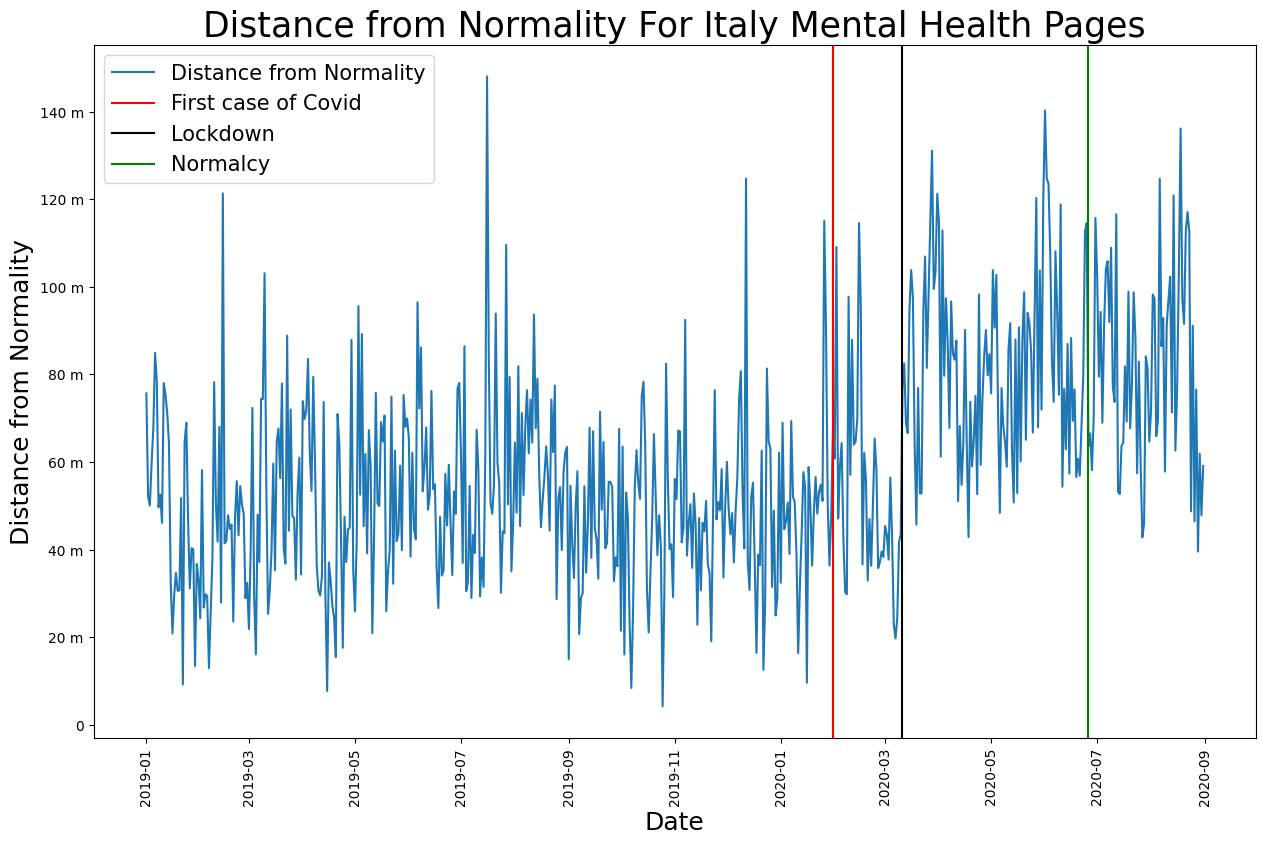

In [35]:
plotDistanceFromNormality('it')

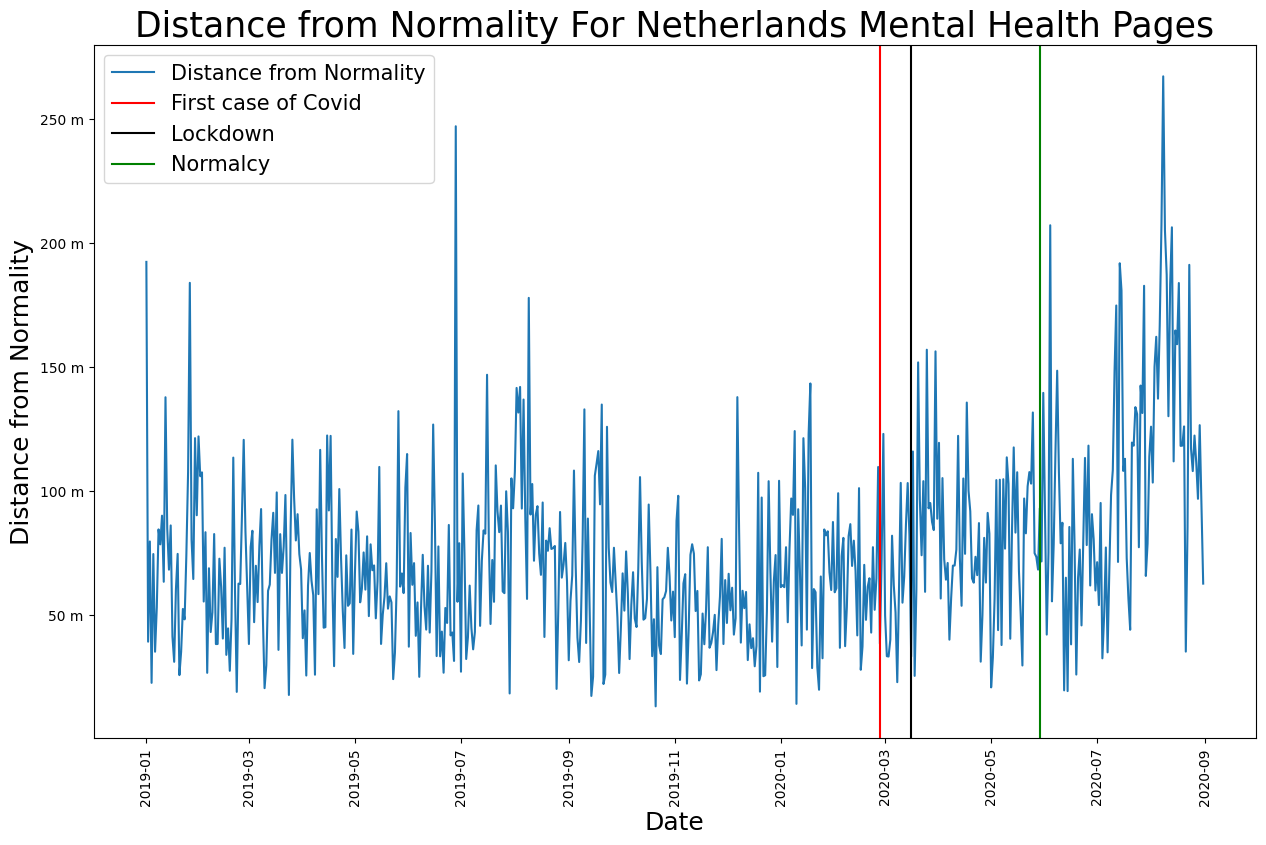

In [36]:
plotDistanceFromNormality('nl')

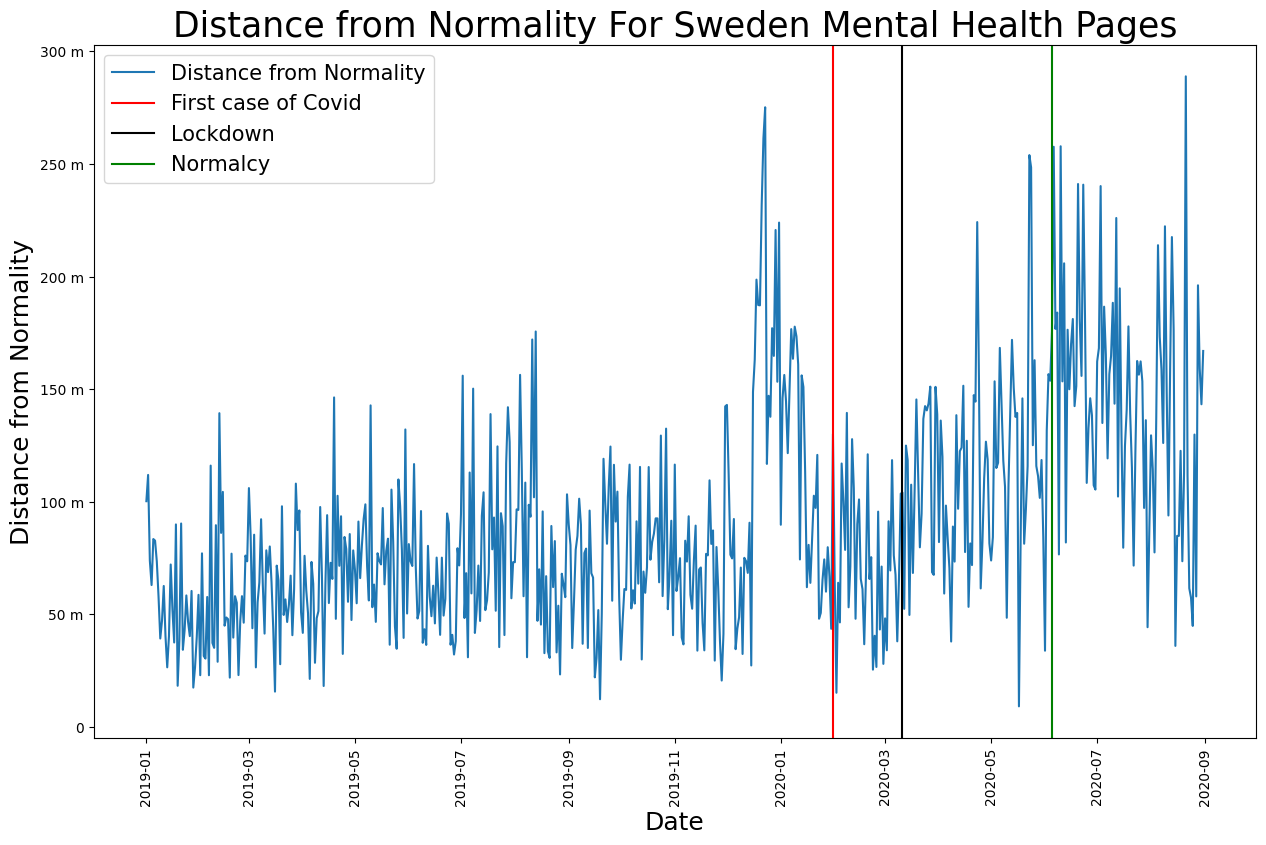

In [37]:
plotDistanceFromNormality('sv')

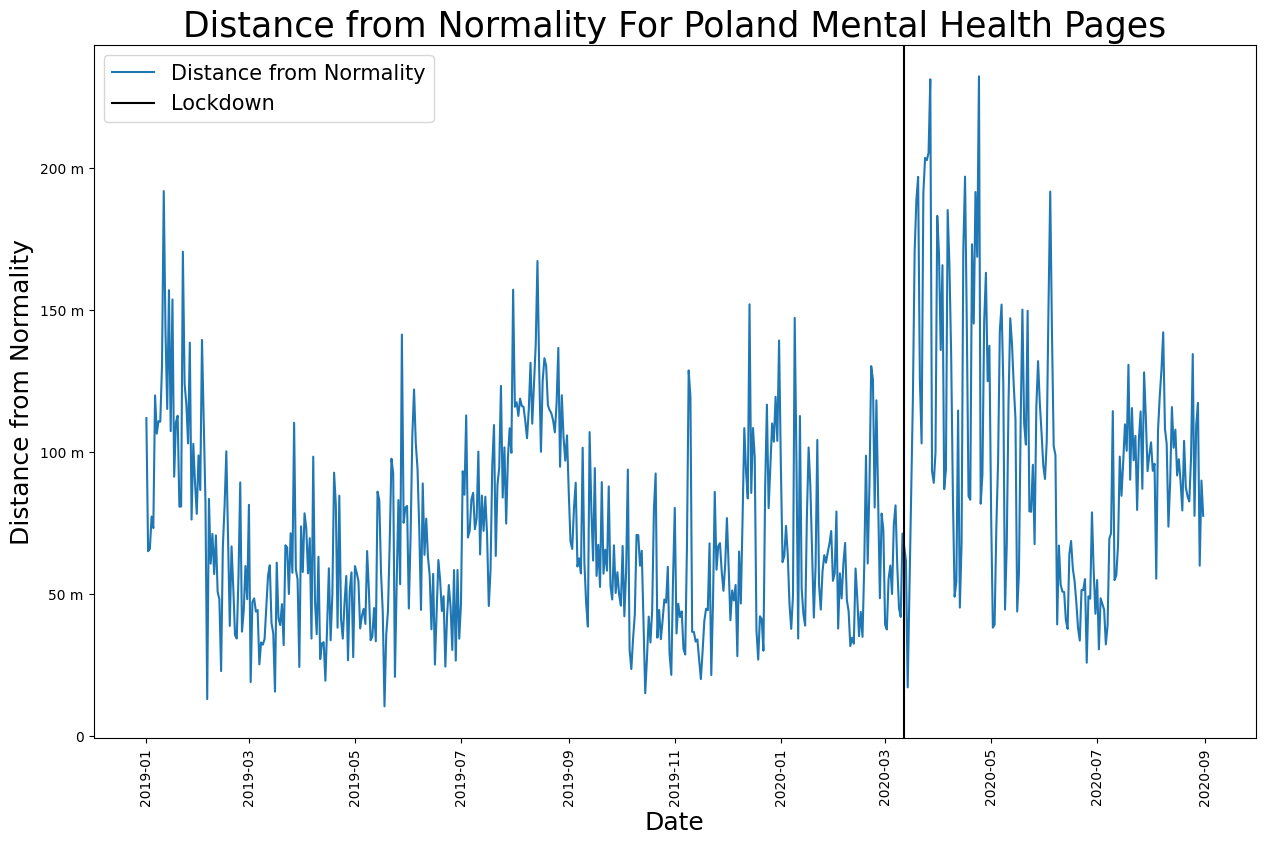

In [38]:
plotDistanceFromNormality('pl')



On the graphs, we see that for Italy and Poland, the distance from the normal attention vector changed significantly during the lockdown. That's why there has been some change in users' attention to mental health topics. There have also been some changes in Sweden, but they started before the lockdown, so the reason for this is not the lockdown. As for the Netherlands, there are no significant changes. These graphs show us the changes in normality for Italy and Poland, but it is unclear in which direction these changes have taken place. Perhaps people have started visiting pages about mental health less. To understand this and go beyond a visual inspection and accurately quantify changes in the volume of pageviews, we will use the "difference in differences" regression approach.

# Difference-in-differences regression.

Difference-in-differences regression is a “quasi-experimental” technique that mimics an experimental design with observational data by studying the effect of a treatment (e.g., lockdown) on a treatment group vs. a control group. The difference-in-differences method aims at separating the true treatment effect from simultaneous (e.g., seasonal) changes that would have occurred even without the treatment. To do so, we calculate the post-minus-pre-treatment difference (in 2020) and compare it to the difference between the corresponding time periods in the previous year (2019). Subtracting the 2019 difference from the 2020 difference (yielding the “difference in differences”) thus removes changes that would have occurred even without the intervention (assuming 2020 would otherwise have looked like 2019) and gives a better estimate of the treatment effect.

We will compare the difference in activity seven weeks before vs. seven weeks after the lockdown. The idea here is to capture what changes were introduced by the sudden halts in human mobility induced by non-phamaceutical interventions.

In this setup, we fix disease and consider, for each language, a time window of 14 weeks (98 days) split around either the lockdown date in 2020, as well as the corresponding time window in 2019. Each of these 196 days contributes one data point per language, for a total of 196 × 4  = 784 data points. As the dependent variable y, we use the logarithm of the number of page views, and as independent variables, the following three factors: year (2019 or 2020), lockdown (before or after the calendar day of lockdown), and language. We now model y as a linear function of these three factors and all their two and three-way interactions. In R formula notation,

y ∼ year * lockdown * language.

Pageview volumes were considered in logarithmic form for two reasons: first, because raw pageview counts are far from normally distributed, with numerous large outliers, and second, because the logarithm makes the model multiplicative, thus implicitly normalizing the estimated effects and making it possible to compare languages with different pageview volumes: if b is the coefficient of the three-way interaction year : lockdown : language, then exp(b) captures the multiplicative factor by which disease pageview volumes in a given language increased when lockdown happened,  after taking into account differences related only to the year or only to lockdown, which are already captured by the coefficients of year : language and lockdown : language, respectively.

In [39]:
# Let's find the lockdown date for each language and the dates 7 weeks before lockdown and 7 weeks after lockdown.
# We also need these dates for 2019.

# dict for storing dates for each language
dates = {}
period_weeks = 7
for lang in LANGUAGES:
    # lockdown date
    start_lockdown_2020 = interventions_data['Lockdown'].loc[lang] 
    if start_lockdown_2020 is pd.NaT:
        start_lockdown_2020 = interventions_data['Mobility'].loc[lang] 
    #7 week before lockdown date
    before_lockdown_2020 = start_lockdown_2020 - relativedelta(weeks=period_weeks)
    #7 week after lockdown date
    after_lockdown_2020 = start_lockdown_2020 + relativedelta(weeks=period_weeks)
    
    # same dates in 2019
    start_lockdown_2019 = start_lockdown_2020 - relativedelta(years=1)
    before_lockdown_2019 = before_lockdown_2020 - relativedelta(years=1)
    after_lockdown_2019 = after_lockdown_2020 - relativedelta(years=1)
    dates[lang] = [before_lockdown_2019, start_lockdown_2019, after_lockdown_2019, before_lockdown_2020, start_lockdown_2020, 
                   after_lockdown_2020]
    
dates

{'nl': [Timestamp('2019-01-27 00:00:00'),
  Timestamp('2019-03-16 00:00:00'),
  Timestamp('2019-05-04 00:00:00'),
  Timestamp('2020-01-27 00:00:00'),
  Timestamp('2020-03-16 00:00:00'),
  Timestamp('2020-05-04 00:00:00')],
 'sv': [Timestamp('2019-01-22 00:00:00'),
  Timestamp('2019-03-11 00:00:00'),
  Timestamp('2019-04-29 00:00:00'),
  Timestamp('2020-01-22 00:00:00'),
  Timestamp('2020-03-11 00:00:00'),
  Timestamp('2020-04-29 00:00:00')],
 'pl': [Timestamp('2019-01-23 00:00:00'),
  Timestamp('2019-03-12 00:00:00'),
  Timestamp('2019-04-30 00:00:00'),
  Timestamp('2020-01-23 00:00:00'),
  Timestamp('2020-03-12 00:00:00'),
  Timestamp('2020-04-30 00:00:00')],
 'it': [Timestamp('2019-01-22 00:00:00'),
  Timestamp('2019-03-11 00:00:00'),
  Timestamp('2019-04-29 00:00:00'),
  Timestamp('2020-01-22 00:00:00'),
  Timestamp('2020-03-11 00:00:00'),
  Timestamp('2020-04-29 00:00:00')]}

In [55]:
# This function checks whether the given date falls within the period under consideration.
def findPeriod(x, lang, dates) -> int:
    if x < dates[lang][0] or (x > dates[lang][2] and x < dates[lang][3]) or x > dates[lang][5]:
        return -1
    if x < dates[lang][1] or (x >= dates[lang][3] and x < dates[lang][4]):
        return 0
    return 1
        

# A function for preparing data for regression.    
def prepareData(dates, disease):
    # new DataFrame for required features.
    new_df = pd.DataFrame({'Year' :[], 'Period':[], 'Language': [], 'PageViews': []})
    for lang in LANGUAGES: 
        # pageviews for a given language
        df = pageviews_data[lang].copy()

        # pageviews for a given language and the required period.
        df['Period'] = df['Date'].apply(lambda x: findPeriod(x, lang, dates))
        df = df[df['Period'] != -1]

        # Take the logarithm of page views
        df['PageViews'] = np.log(df[disease])

        # Add categorical feature language.
        df['Language'] = [lang]*len(df)

        # add to new dataframe
        new_df = pd.concat([new_df, df[new_df.columns]])
    return new_df
            
# A function for findinf sem
def get_standard_error_sum(results, covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    # get the variance covariance matrix
    vcov = results.cov_params() \
        .loc[covariates, covariates].values

    # calculate the sum of all pair wise covariances by summing up off-diagonal entries
    off_dia_sum = np.sum(vcov)
    # variance of a sum of variables is the square root
    return np.sqrt(off_dia_sum)
    
# A function for determining the expected logarithmic effect of lockdown on the number of page views of the given disease.
def get_diffs_in_diffs_result(dates, disease):
    df = prepareData(dates, disease)
    # Regression formula    
    np.random.seed(2)
    res = smf.ols(formula='PageViews ~  C(Year) * C(Period) * C(Language)', data=df).fit()
    res = res.get_robustcov_results(cov_type='HC0')
    res = statsmodels.regression.linear_model.RegressionResultsWrapper(res)
    
    # Print summary
    print('\n Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) \n')
    print(res.summary())
    

    df_list = []
    
    # For each language find the estimated logarithmic effects of lockdown on volume of page views of the given disease.
    for lang in LANGUAGES:
        if lang == 'it':
            val = res.params['C(Year)[T.2020]:C(Period)[T.1.0]']
            std = get_standard_error_sum(res, ['C(Year)[T.2020]:C(Period)[T.1.0]'])
        else:                                
            val = res.params['C(Year)[T.2020]:C(Period)[T.1.0]'] + \
                  res.params['C(Year)[T.2020]:C(Period)[T.1.0]:C(Language)[T.{}]'.format(lang)] 
                 

            std = get_standard_error_sum(res, ['C(Year)[T.2020]:C(Period)[T.1.0]',
                                               'C(Year)[T.2020]:C(Period)[T.1.0]:C(Language)[T.{}]'.format(lang)])
    

        tmp_dict = {
            "lang": lang, # language
            "low": val - 2 * std, # begin of CI
            "high": val + 2 * std, # end of CI
            "val": val, # the value of effect
            "pval": (val - 2 * std > 0) or (val + 2 * std < 0), # Is the effect significant?
            "std": std
        }

        df_list.append(tmp_dict)

    return pd.DataFrame(df_list)

# Function for plotting the effect for each country
def plot_diffs_in_diffs_all(dates, disease):
    df_results = get_diffs_in_diffs_result(dates, disease)
    df_results = df_results.reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(14, 8), sharex="col",
                       gridspec_kw={"hspace": 0.075, "wspace": 0.05, "top": 0.9, "bottom":0.15})

    idx = 0
    labels = []
    for lang in LANGUAGES:
        
        row = df_results[(df_results.lang == lang)].iloc[0]
        row = dict(row)
        if row["pval"]: 
            print('\n\nRelative Increase (log) in {}: {}'.format(region[lang], row['val']))
        # desktop ci
        ax.plot([row["low"], row["high"]], [idx, idx], color="#e41a1c", zorder=1)

        # desktop mean
        marker = "." if row["pval"] else "x"
        ax.scatter([row["val"]], [idx], color="black", marker=marker, zorder=2)


        ax.axhline(idx + 0.5, lw=0.5, ls=":", color='black', alpha=0.5)

        idx += 1
        labels.append(region[row["lang"]])

        _ = ax.set_yticks(range(0, idx))
        _ = ax.set_yticklabels(labels, fontsize=20)

        ax.set_ylim([-0.5, 11.5])
        
    ax.axvline(0, zorder=0, color="black", ls="-", alpha=0.3)

    ax.set_xlim([-0.6, 0.6])
    ax.set_xticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.yaxis.tick_right()
    ax.set_title('Relative Increase ($\log_e$) in page views for a Wikipedia article "{}" during lockdown'.format(disease), size=25)
    ax.set_xlabel("Relative Increase ($\log_e$)", size=20)
    lines = [
        Line2D([0], [0], color="black", lw=0, marker="x"),

    ]

    ax.legend(
        handles=lines,
        labels=["NOT SIGNIFICANT: p $>$ 0.05"],
        loc='center',
        fancybox=True, shadow=False,
        frameon=False, edgecolor=None, fontsize=12,
        borderaxespad=0
    )
    plt.show()



 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1122.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:09:21   Log-Likelihood:                 66.971
No. Observations:                 788   AIC:                            -101.9
Df Residuals:                     772   BIC:                            -27.23
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

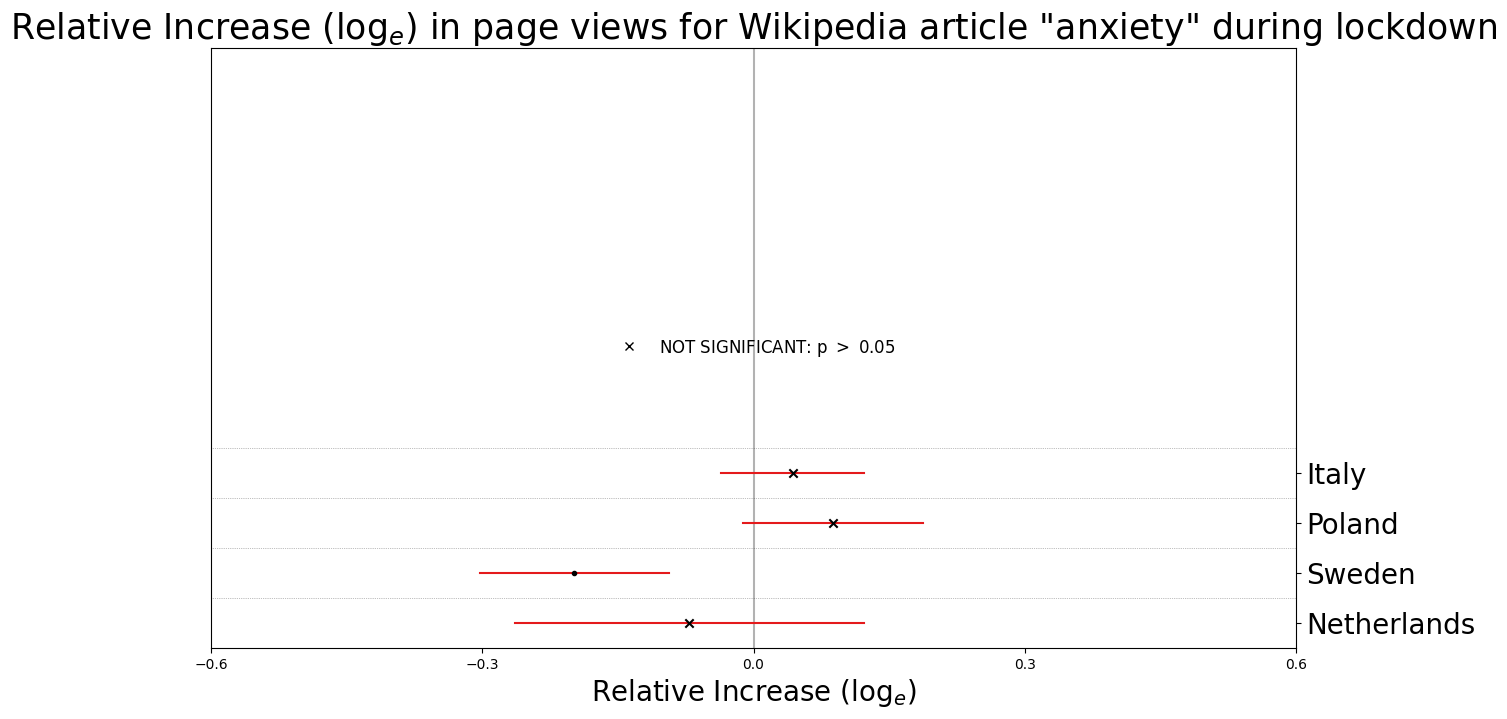

In [56]:
plot_diffs_in_diffs_all(dates, 'anxiety')

The estimated logarithmic effects of lockdown on the volume of pageviews is plotted for **anxiety** by countries. We can see that the logarithmic pre-vs.-post lockdown effect on the Sweden version is around -0.2 (corresponding to a decrease in pageviews to exp(-0.2) ≈ 81%). For other countries, we see insignificant effects. This is quite expected, since during the lockdown people did not go to work, school, or university, but stayed at home, so there were few reasons for anxiety, accordingly, less or equal interest in an article about anxiety. Let's see the plot of pageviews of the article 'anxiety' in the Swedish language in order to observe the effect visually.

In [78]:
#A function for plotting the average number of pageviews by month for all disorders and for a given period
# [start_date, end_date]



def plotDisorderPageViews(lang, disease, start_date, end_date, errorbar='sd'):
    # consider data for the given language
    df = pageviews_data[lang].copy()
    # consider only data in period [start_date, end_date]
    data = df[(df['Date'].dt.date >= start_date.date())  &  
              (df['Date'].dt.date <= end_date.date())]
    
    fig, ax = plt.subplots(figsize=(20, 12))
    plt.title('The monthly average number of page views for a Wikipedia article "{}" from {} to {} in {}'.format(disease, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), region[lang]), fontsize=30)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    # plot horizontal lines for the dates of '1st case', lockdown and Normalcy dates.
    sns.lineplot(data = data, x = "Date", y = disease, label = disease, errorbar=errorbar)
    try:
        plt.axvline(interventions_data.loc[lang]['1st case'], color = 'red', label = 'First case of Covid')
    except:
        pass
    try:
        plt.axvline(interventions_data.loc[lang]['Lockdown'], color = 'black', label = 'Lockdown')
    except:
        plt.axvline(interventions_data.loc[lang]['Mobility'], color = 'black', label = 'Lockdown')
    try:
        plt.axvline(interventions_data.loc[lang]['Normalcy'], color = 'green', label = 'Normalcy')
    except:
        pass
    # Put the date on the x axis vertically 
    ax.tick_params(axis='x', labelrotation=90)
    plt.xlabel('Month', fontsize=20)
    plt.ylabel('PageViews', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

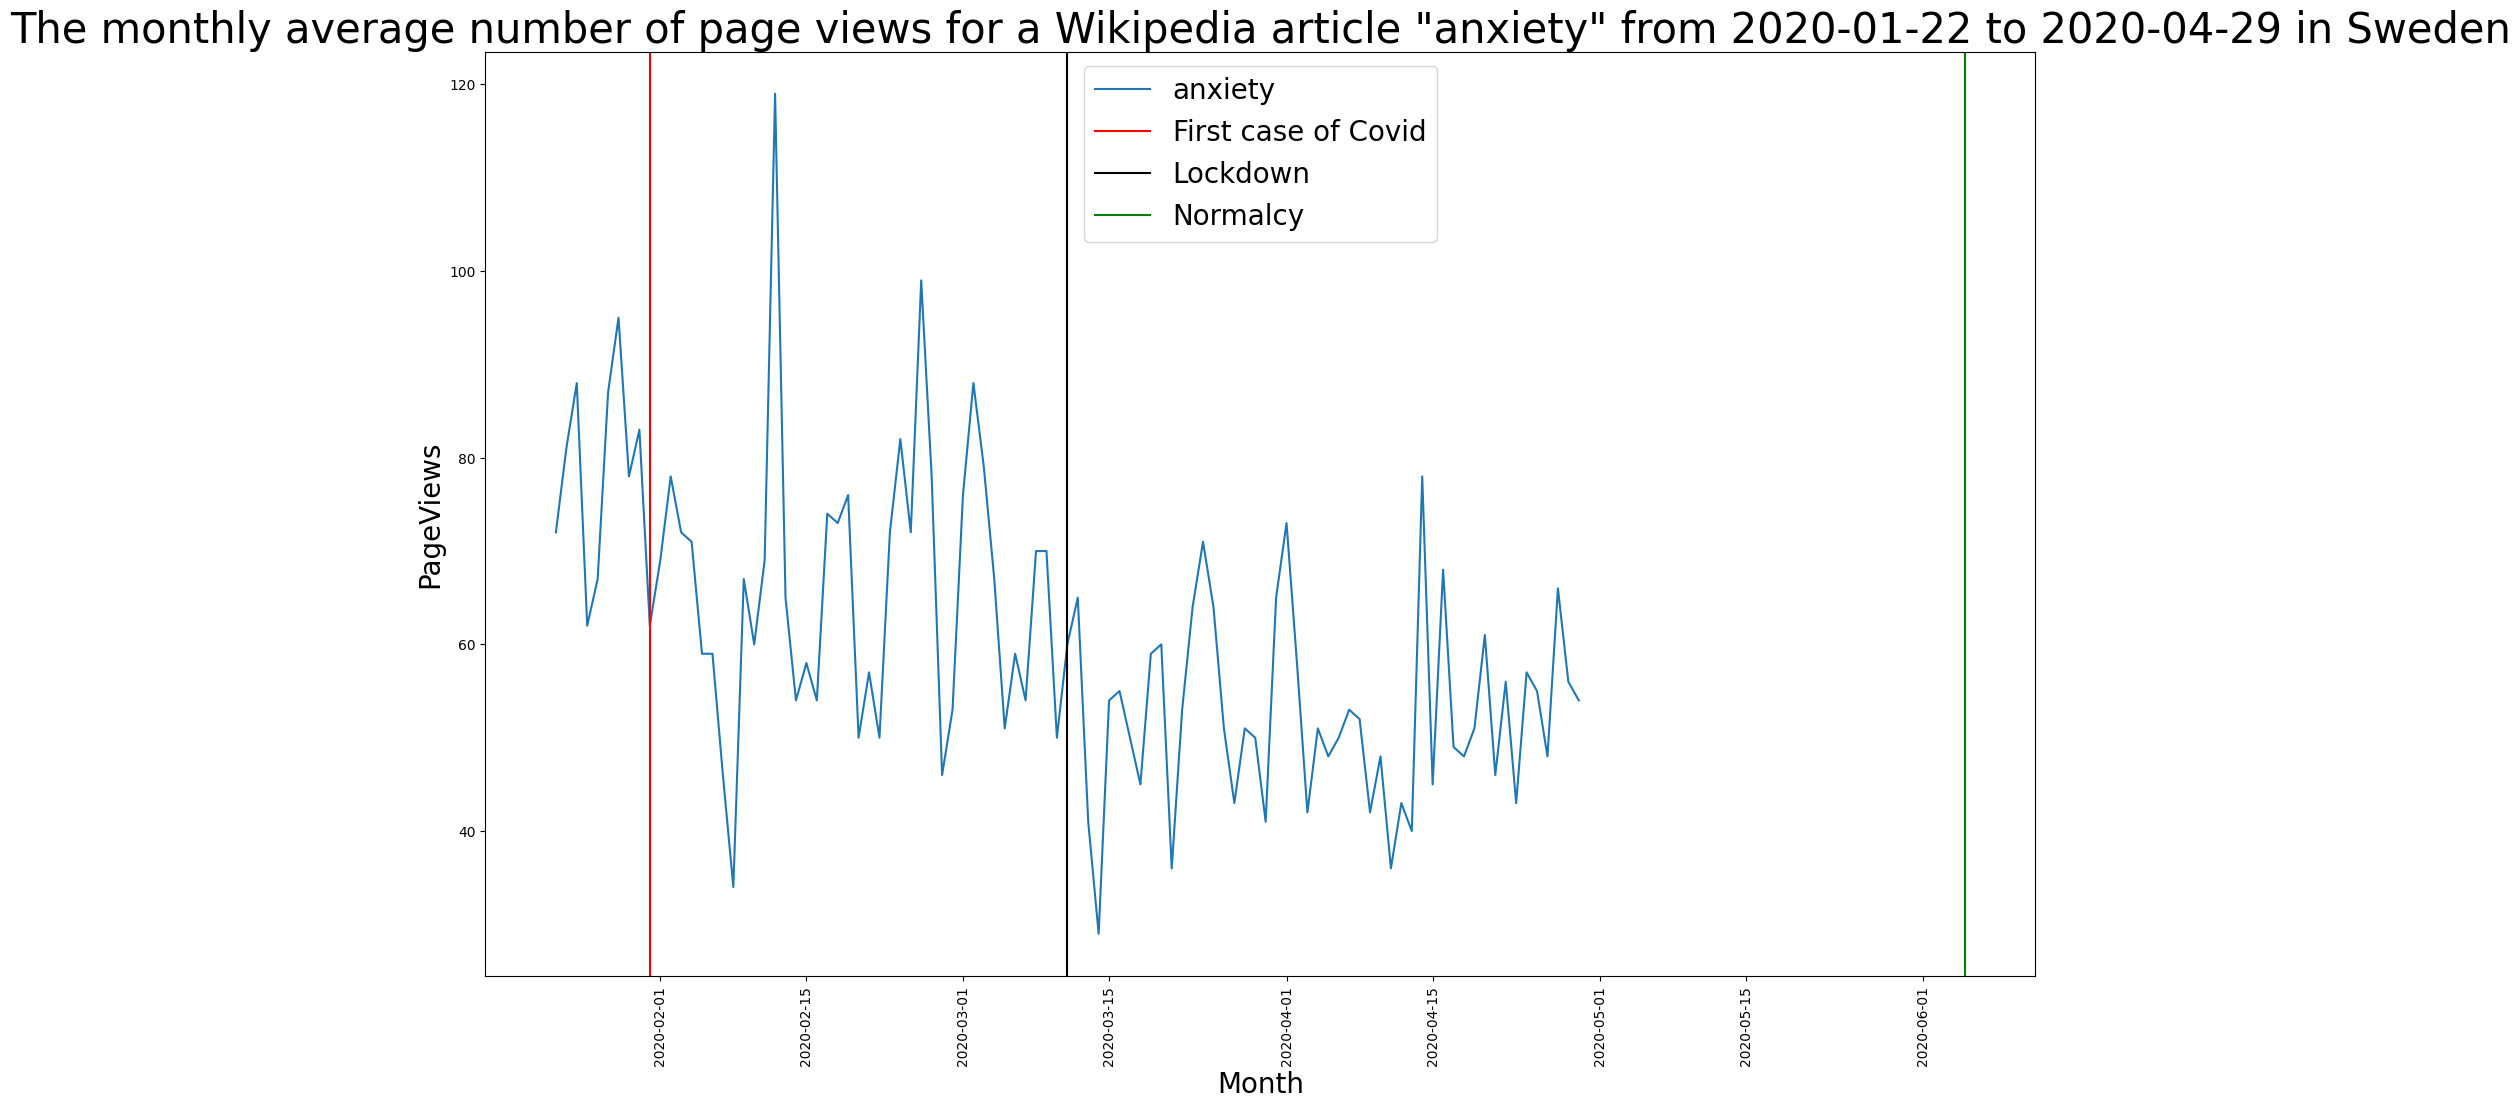

In [79]:
plotDisorderPageViews('sv', 'anxiety', dates['sv'][3], dates['sv'][5])

In the plot above we can see that really during the lockdown the volume of pageviews for the article 'anxiety' in Sweden language decreased. Let's see what happened with other disorders.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     974.3
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:17:25   Log-Likelihood:                 294.86
No. Observations:                 788   AIC:                            -557.7
Df Residuals:                     772   BIC:                            -483.0
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

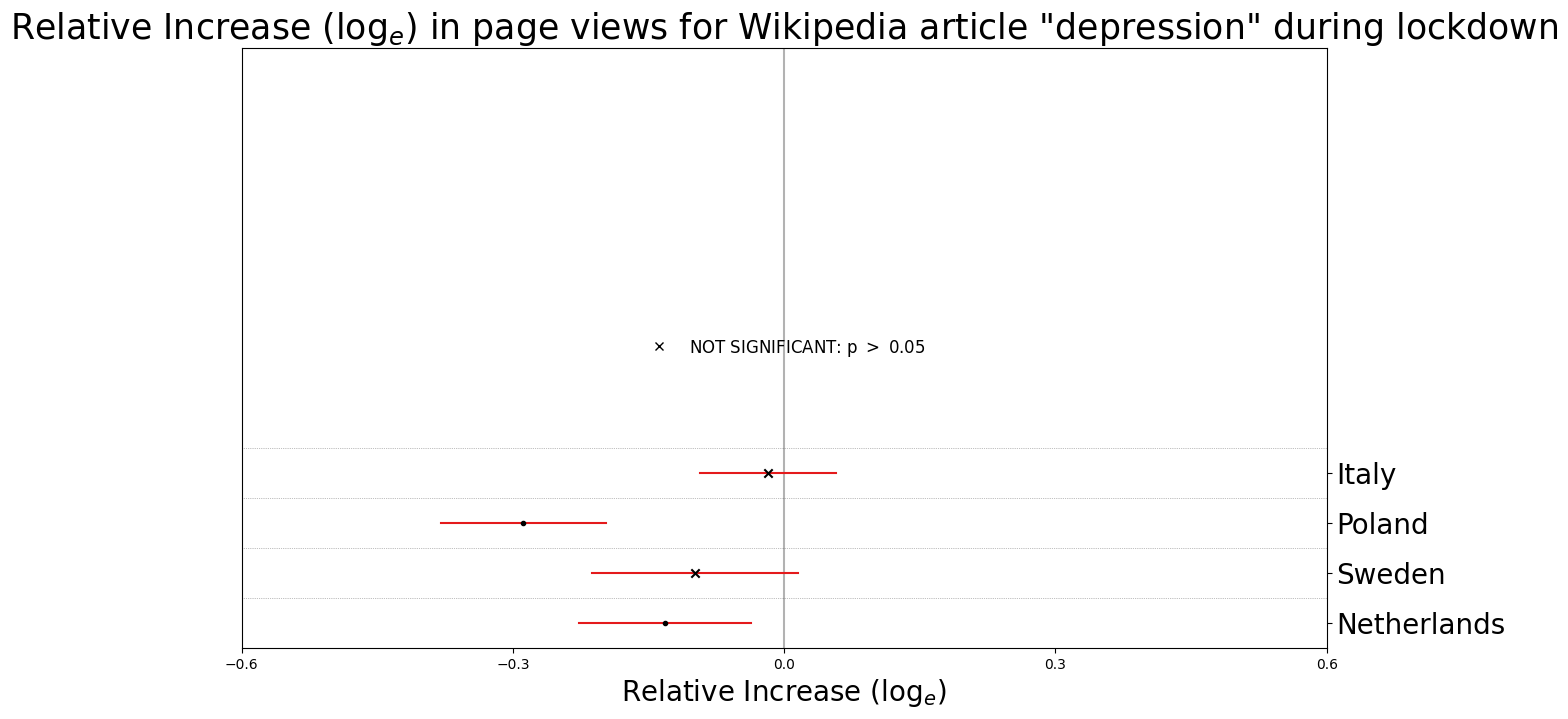

In [80]:
plot_diffs_in_diffs_all(dates, 'depression')

The estimated logarithmic effects of lockdown on the volume of pageviews is plotted for **depression** by countries. Here we can see that the logarithmic pre-vs.-post lockdown effect on the Netherlands version is around -0.13 (corresponding to a decrease in pageviews to exp(-0.123) ≈ 87%) and on the Poland version is around -0.13 (corresponding to a decrease in pageviews to exp(-0.29) ≈ 74%). For other countries, we see insignificant effects. It's a little strange that the number of page views about depression has not increased, and in some countries, it has even decreased on the contrary. Let's see the plot of pageviews of the article **depression** in Dutch and Polish languages in order to observe the effects visually.

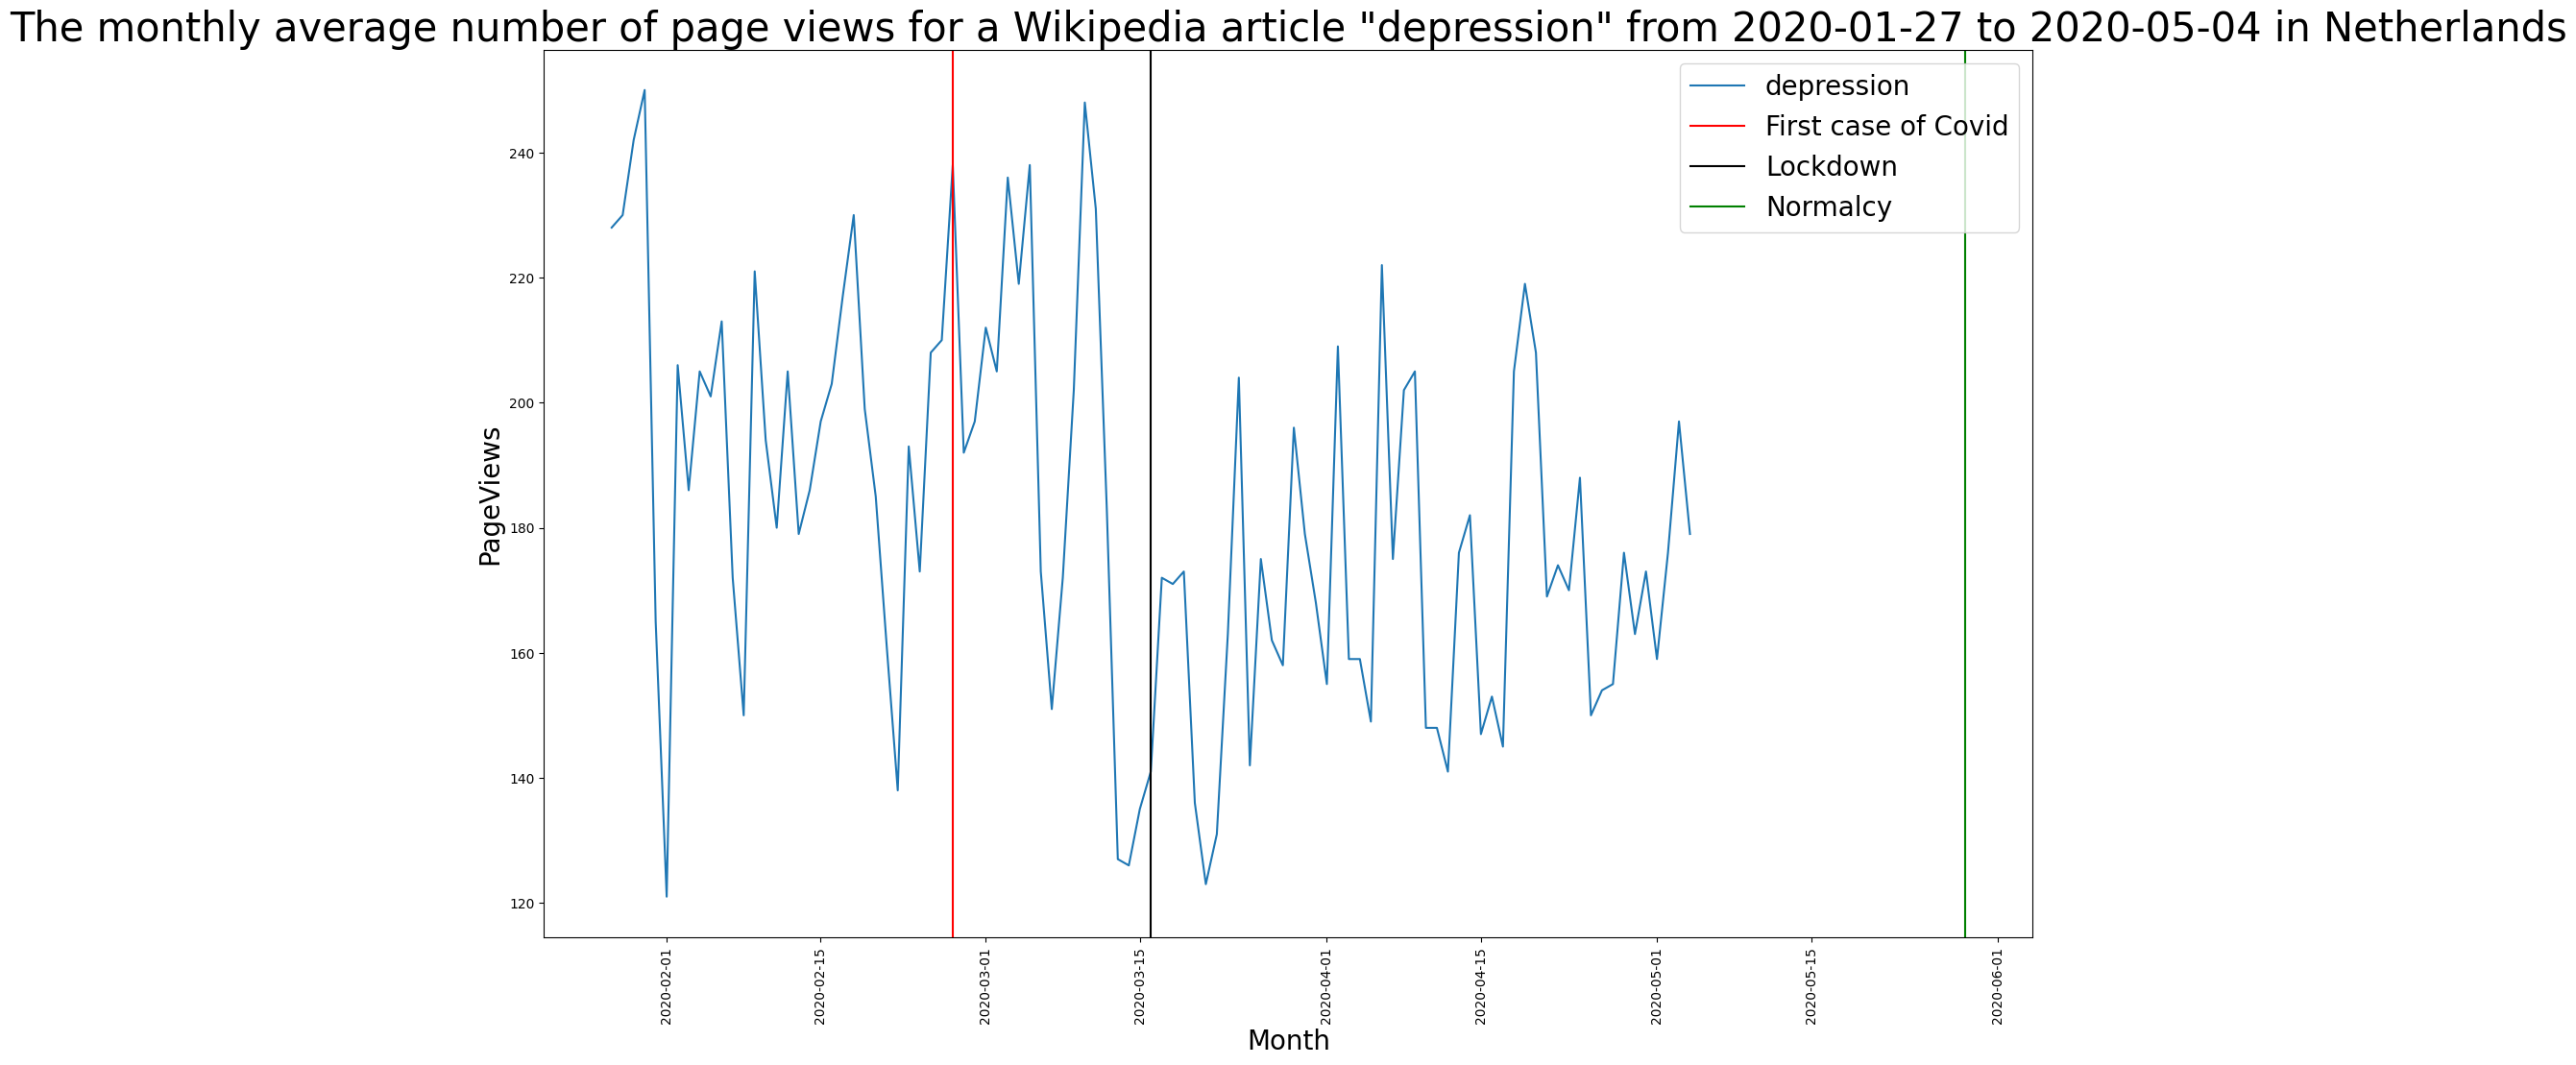

In [81]:
plotDisorderPageViews('nl', 'depression', dates['nl'][3], dates['nl'][5])

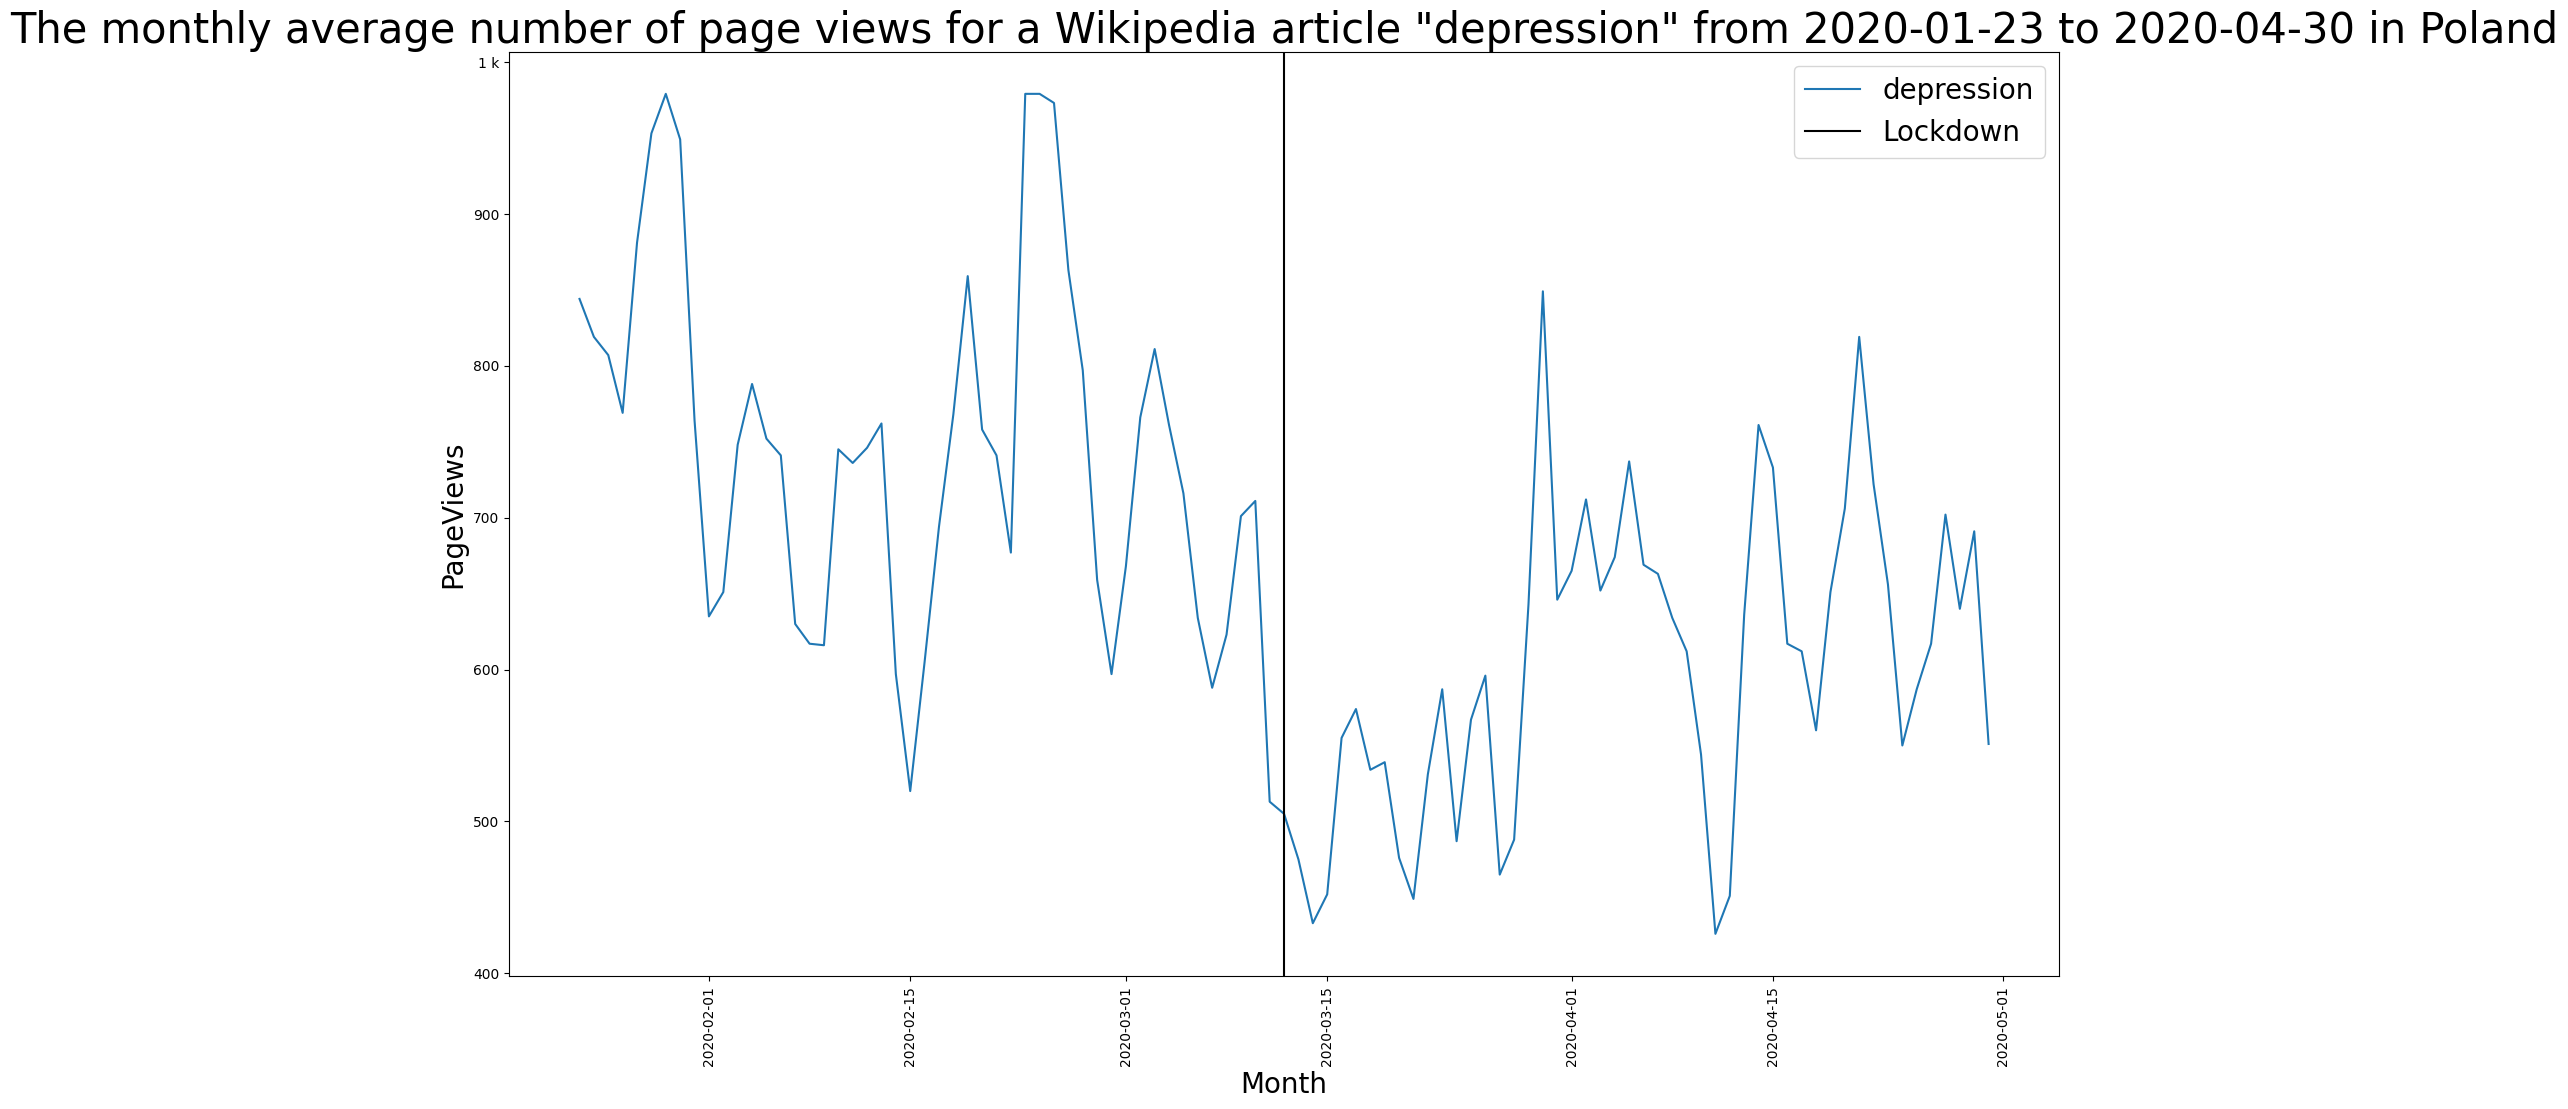

In [82]:
plotDisorderPageViews('pl', 'depression', dates['pl'][3], dates['pl'][5])

Here also the effect is seen visually.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     389.9
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:18:09   Log-Likelihood:                 45.793
No. Observations:                 788   AIC:                            -59.59
Df Residuals:                     772   BIC:                             15.13
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

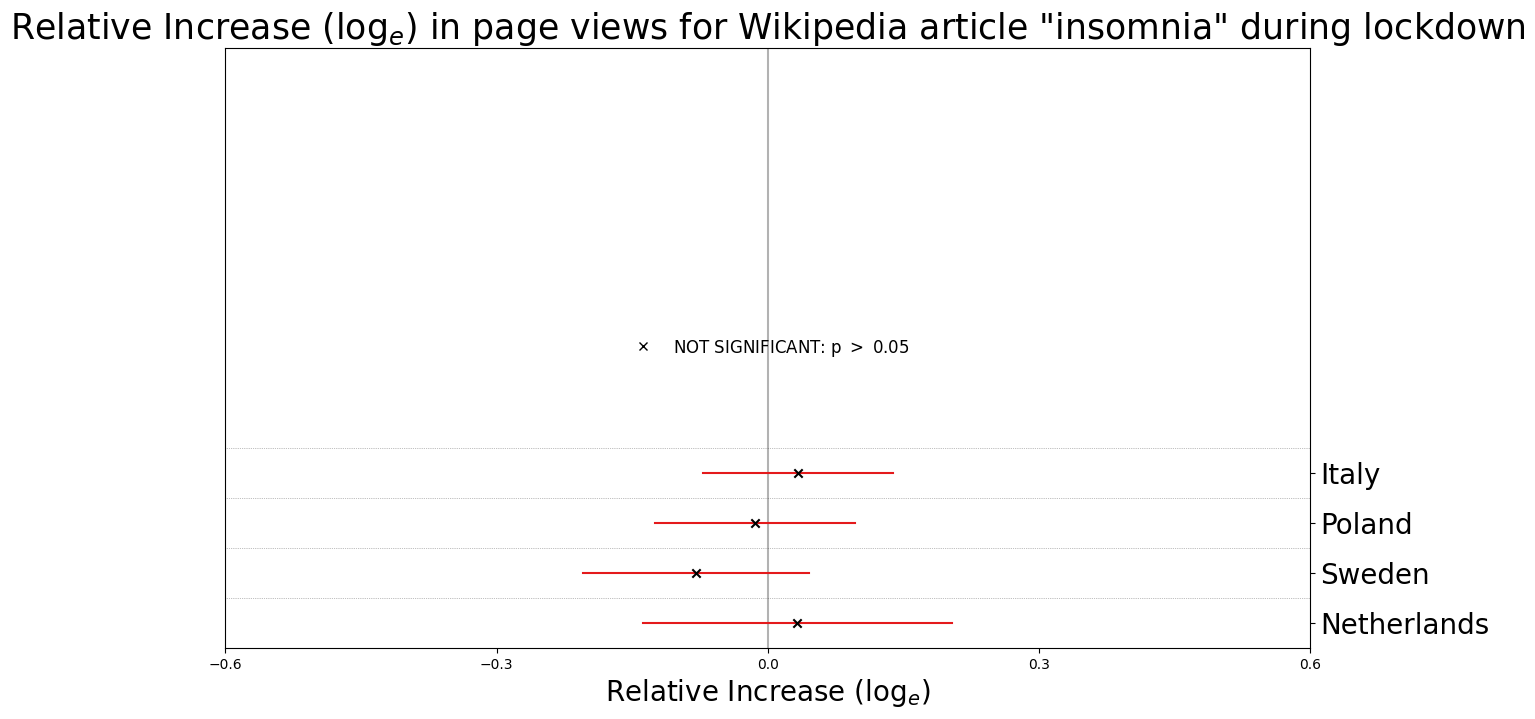

In [83]:
plot_diffs_in_diffs_all(dates, 'insomnia')

For this disorder, we can't say anything because all our results are insignificant.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     470.6
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:18:10   Log-Likelihood:                -189.89
No. Observations:                 788   AIC:                             411.8
Df Residuals:                     772   BIC:                             486.5
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

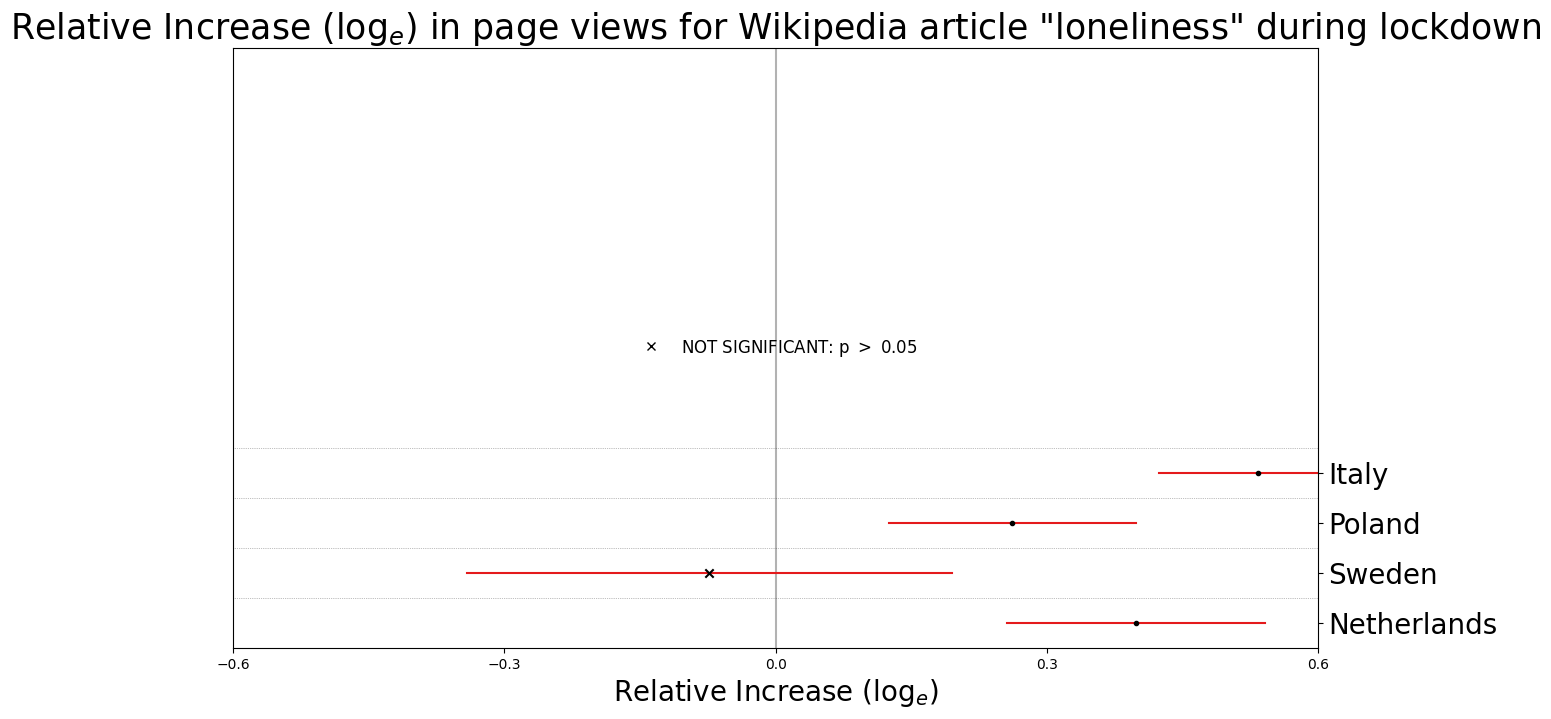

In [84]:
plot_diffs_in_diffs_all(dates, 'loneliness')

Here we can see that the logarithmic pre-vs.-post lockdown effect on the Netherlands version is around 0.4 (corresponding to a increase in pageviews to exp(0.4) ≈ 149%), and on the Poland version is around 0.26 (corresponding to a increase in pageviews to exp(0.26) ≈ 129%) and on the Italy version is around 0.53 (corresponding to a increase in pageviews to exp(0.53) ≈ 169%). For Sweden the effect is insignificant. This increase in page views can be explained by the fact that during the quarantine, a significant number of people stayed at home alone, and since the quarantine lasted for a long time, they began to feel lonely. Let's see the plot of pageviews of the article **loneliness** in Dutch, Polish, and Italian languages to observe the effects visually.

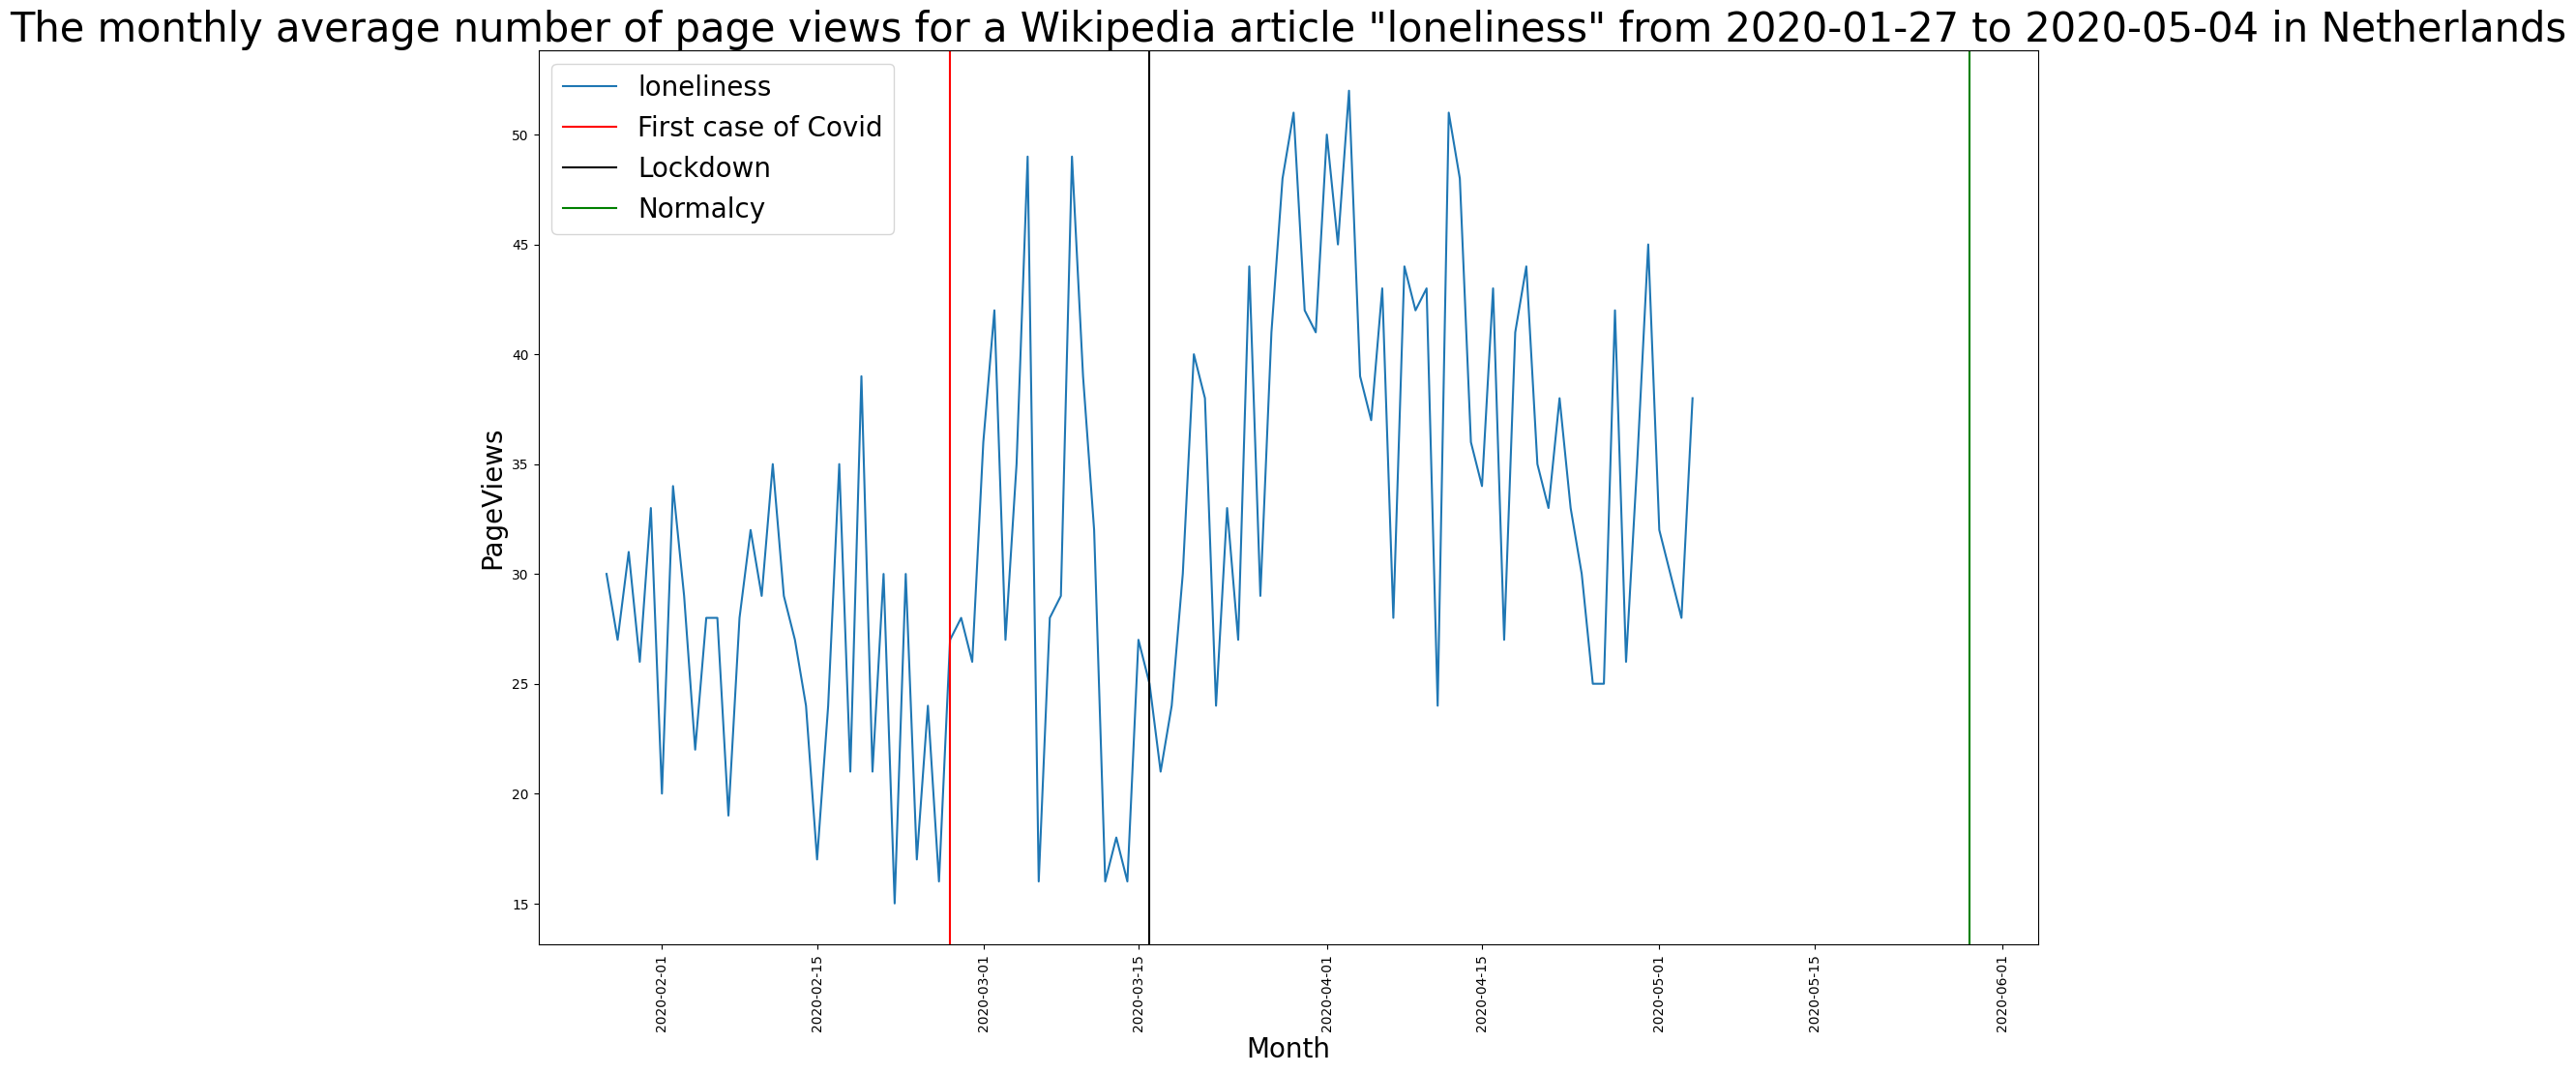

In [85]:
plotDisorderPageViews('nl', 'loneliness', dates['nl'][3], dates['nl'][5])

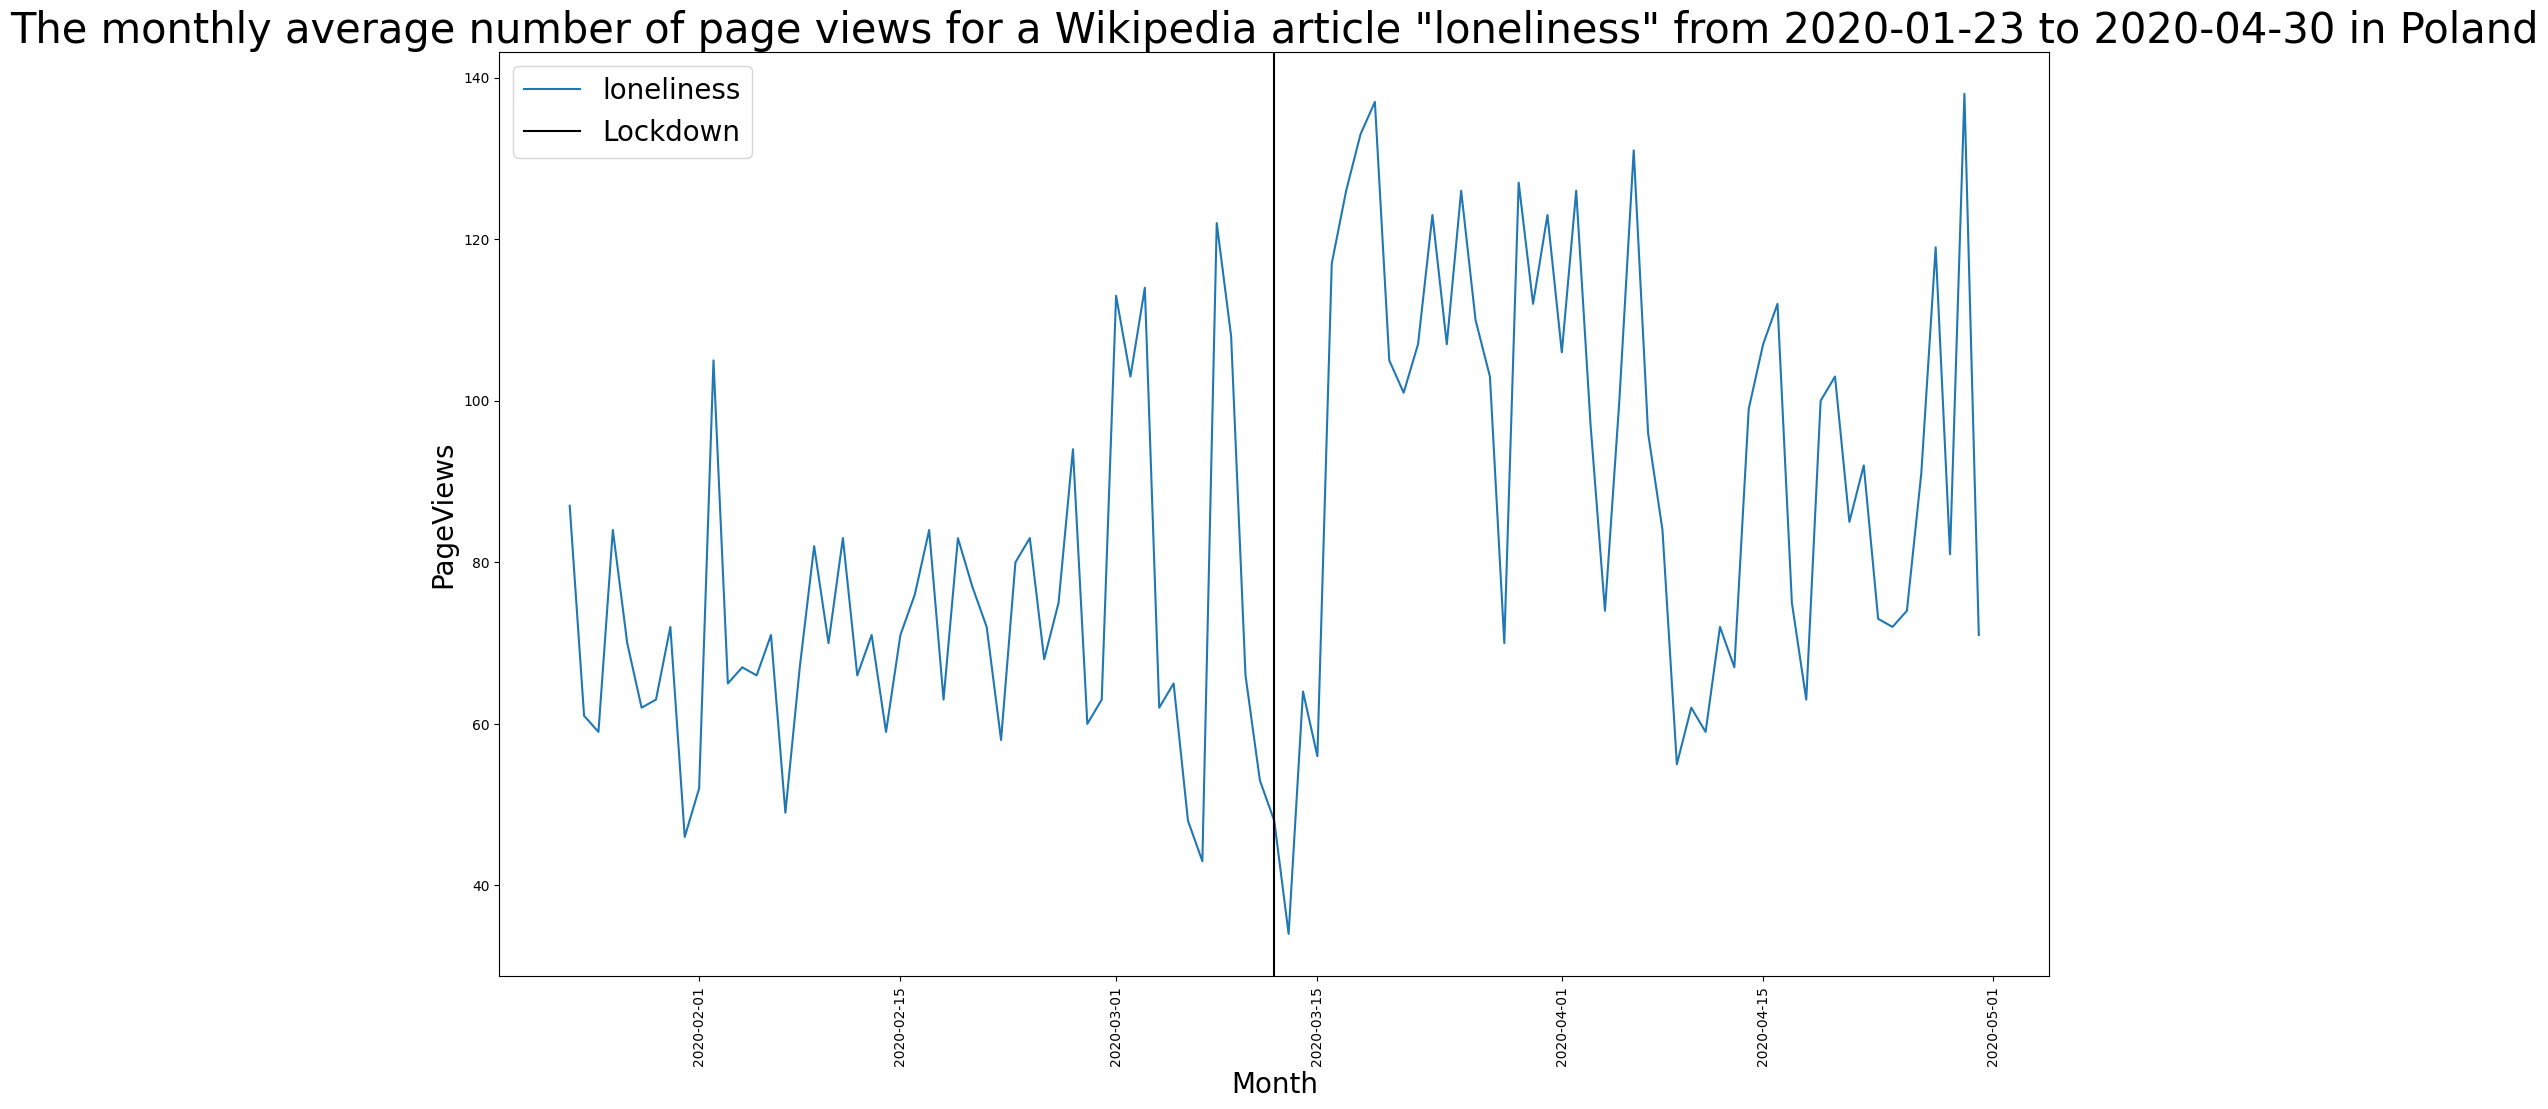

In [86]:
plotDisorderPageViews('pl', 'loneliness', dates['pl'][3], dates['pl'][5])

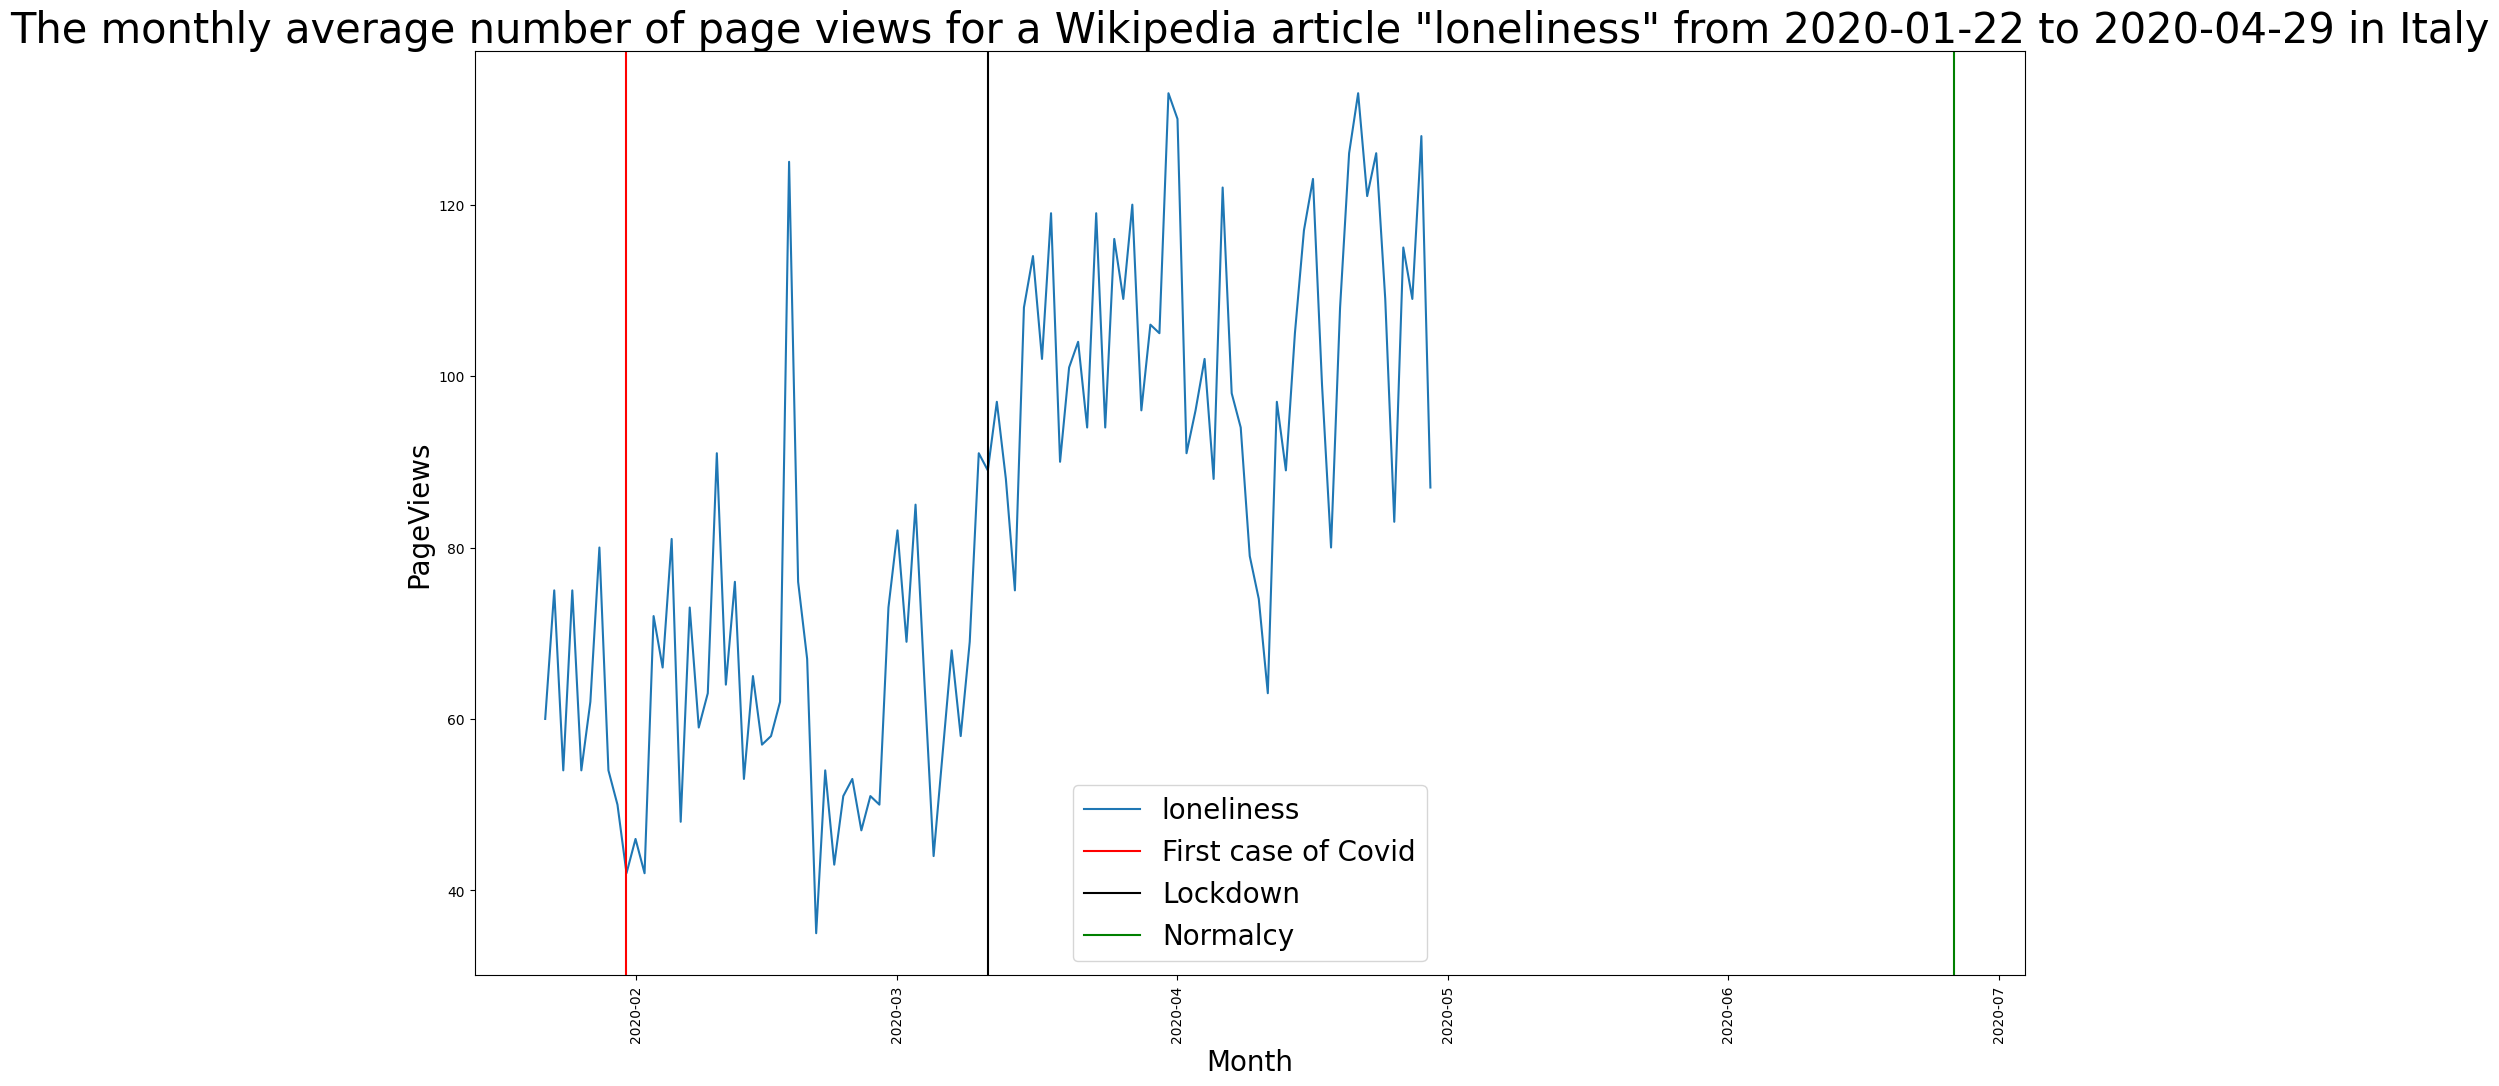

In [87]:
plotDisorderPageViews('it', 'loneliness', dates['it'][3], dates['it'][5])

Here also the effect is seen visually. Let's see for the final disorder 'stress'.


 Regression: log(PageViews) ~  C(Year) * C(lockdown) * C(Language) 

                            OLS Regression Results                            
Dep. Variable:              PageViews   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     209.0
Date:                Thu, 22 Dec 2022   Prob (F-statistic):          1.25e-259
Time:                        16:18:15   Log-Likelihood:                -98.285
No. Observations:                 788   AIC:                             228.6
Df Residuals:                     772   BIC:                             303.3
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------

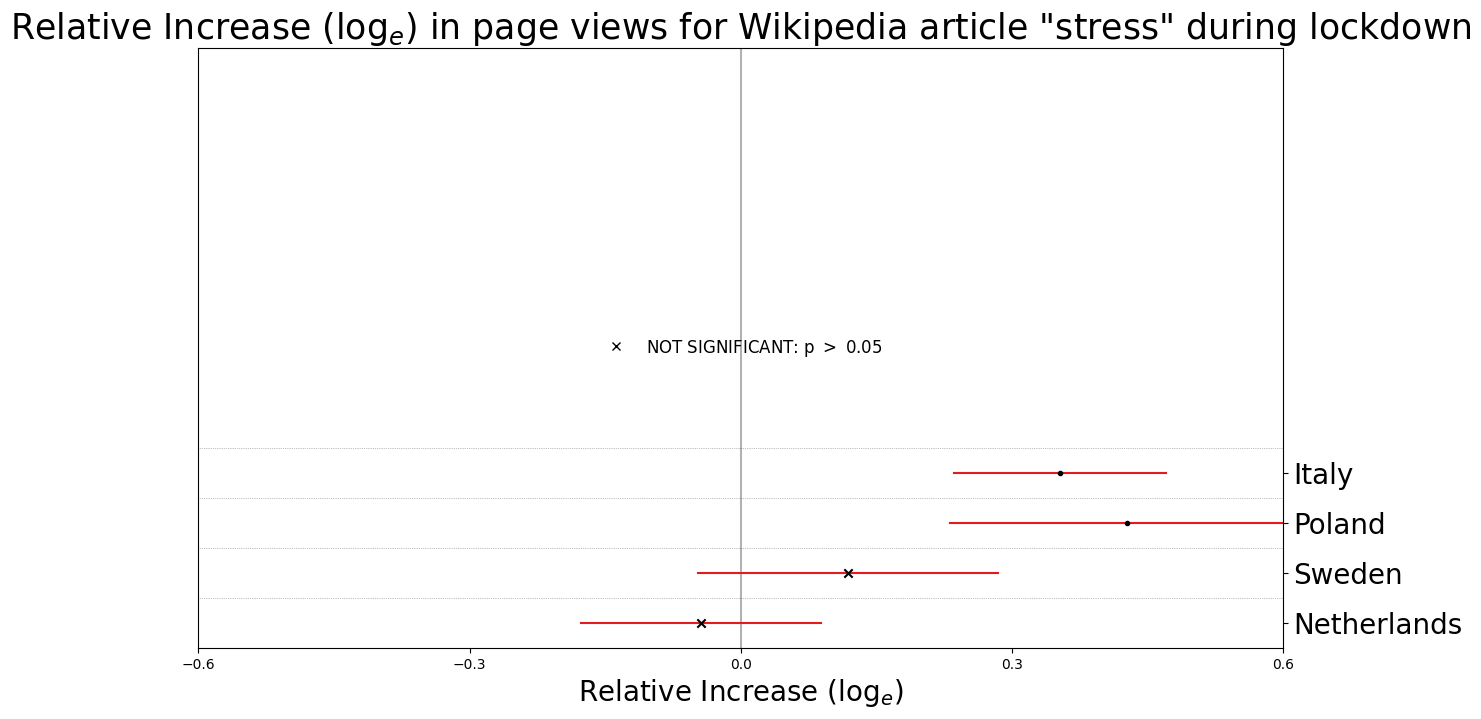

In [88]:
plot_diffs_in_diffs_all(dates, 'stress')

Here we can see that the logarithmic pre-vs.-post lockdown effect on the Polish version is around 0.42 (corresponding to a increase in pageviews to exp(0.42) ≈ 152%) and on the Italian version is around 0.35 (corresponding to a increase in pageviews to exp(0.35) ≈ 141%). For Sweden and Netherlands, the effect is insignificant. Let's see the plot of pageviews of the article **stress** in Polish and Italian languages to observe the effects visually.

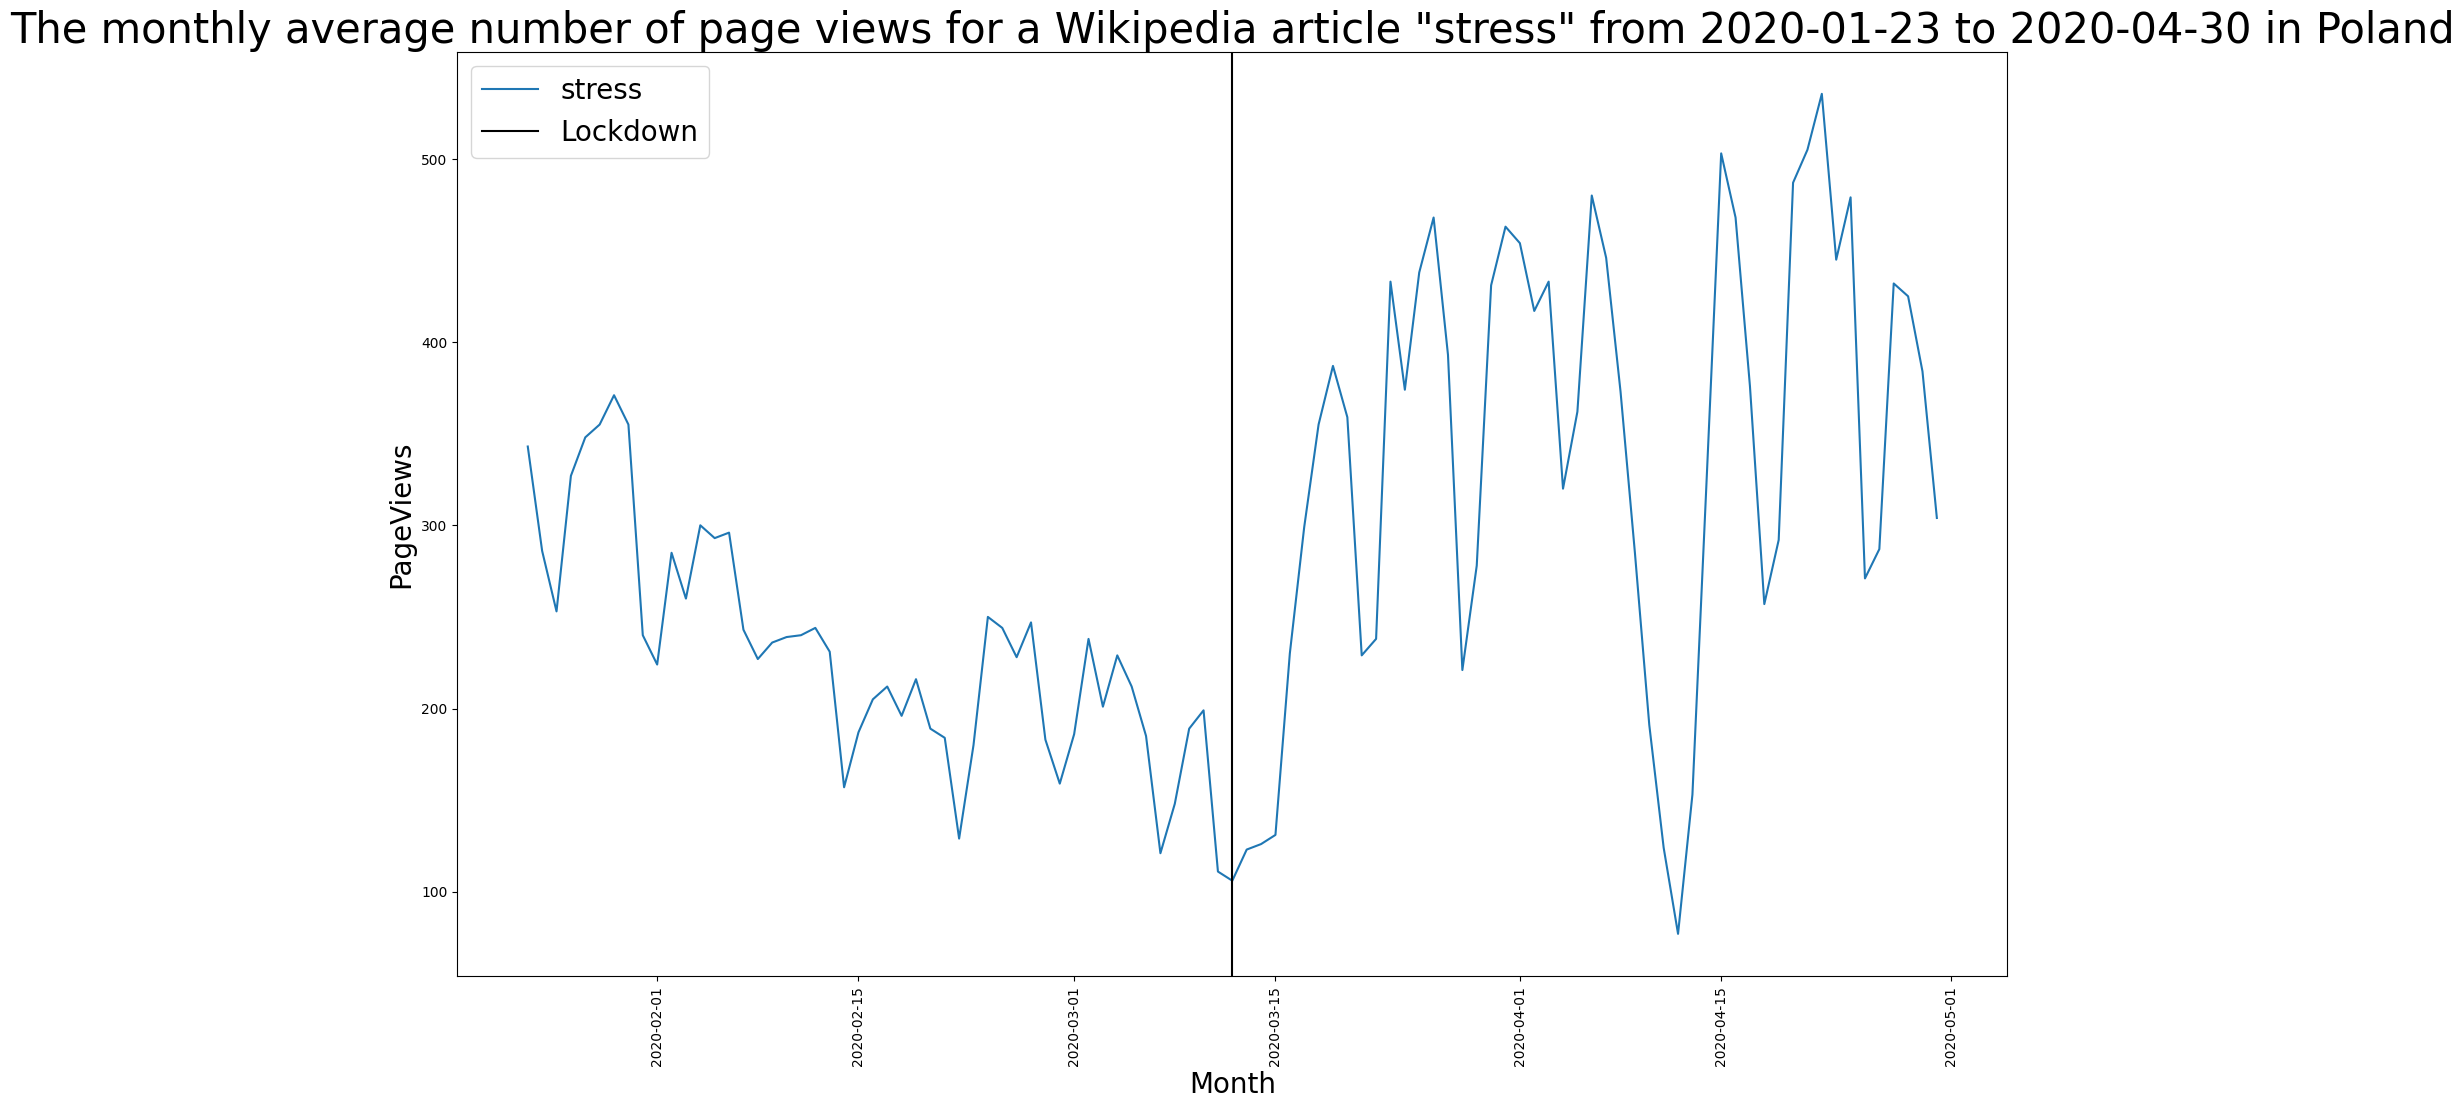

In [89]:
plotDisorderPageViews('pl', 'stress', dates['pl'][3], dates['pl'][5])

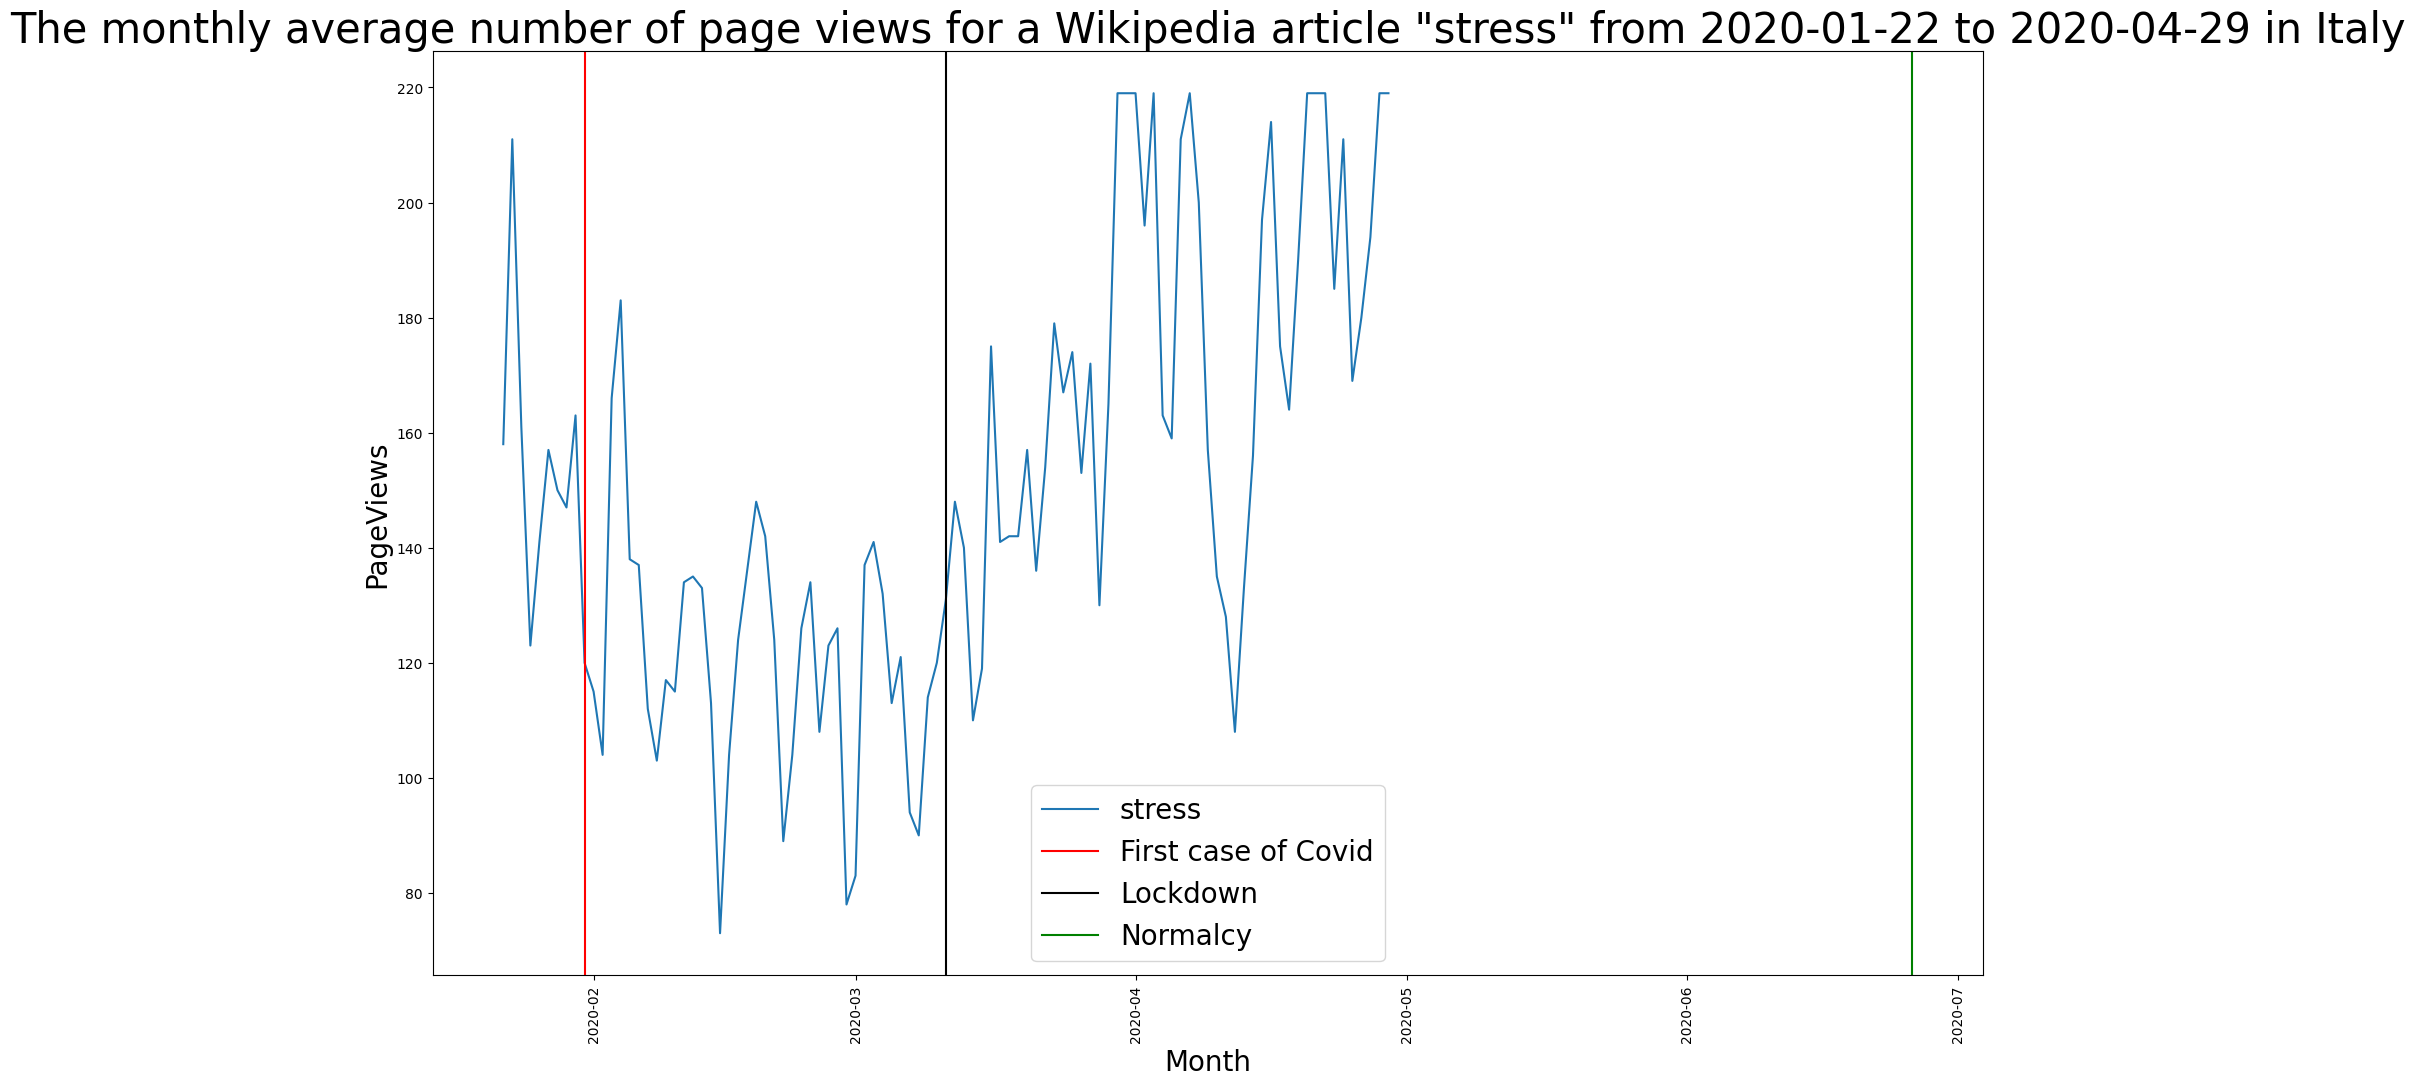

In [90]:
plotDisorderPageViews('it', 'stress', dates['it'][3], dates['it'][5])

Here also the effect is seen visually.